## Download Dataset e Pretrained model


In [ ]:
!git clone https://github.com/Bottins/FeatureImage_Analysis

Cloning into 'FeatureImage_Analysis'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 38 (delta 12), reused 34 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 17.42 MiB | 19.64 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## Setup e dipendenze

**Configuriamo l’ambiente e le dipendenze essenziali**  
 Scikit‑learn per i modelli, Pandas/Numpy per la manipolazione dei dati tabellari e per il calcolo numerico su array multidimensionali, Matplotlib & Seaborn per creare grafici in 2D e per la visualizzazione statistica, StandardScaler standardizza le feature portandole a media 0 e deviazione standard 1 (fondamentale per modelli come SVM, PCA), PCA per la riduzione dimensionale, T-SNE per la riduzione dimensionale non lineare,  perarsonr per calcolare la correlazione di Pearson tra due variabili
(indica quanto due feature sono linearmente correlate), Counter per contare gli elementi in una lista/array, arff per la lettura del file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
from collections import Counter
from scipy.io import arff


# TOOL EDA

## Funzioni utili

Aggiunta di funzioni utili all'analisi esplorativa del dataset in questione. La prima cosa che facciamo è caricare il file .arff e convertirlo in un pandas.DataFrame, in modo tale da renderlo più comodo per l'analisi esplorativa, e convertiamo poi le etichette rappresentate come stringhe **'TRUE'** e **'FALSE'** in valori booleani True/False. Dopo aver fornito una panoramica approfondita sulla distribuzione delle etichette nel dataset, abbiamo graficamente mostrato:

*   la frequenza assoluta di ogni etichetta;
*   la distribuzione percentuale (con plt.pie);
*   bar plot di quante etichette ha ciascun campione;
*   media, mediana, deviazione standard, minimo e massimo del numero di etichette per campione.

Valutata la densità del dataset, analizzate le combinazioni di etichette che appaiono insieme nei campioni e contato quante volte ogni combinazione si verifica nel dataset, sono stati generati: un istogramma delle frequenze, un bar plot delle top combinazioni e una matrice delle co-occorrenze delle etichette.

E' stata effettuata poi un'analisi delle future numeriche per avere una panoramica statistica e visiva al fine di identificare distribuzioni anomale, necessità di preprocessing e valori fuori scala.
Vediamo adesso dal punto di vista della visualizzazione, i vari grafici generati cosa ci permettono di notare:

*   **Istogramma delle medie**: mostra come sono distribuite le medie tra le feature;
*   **Istogramma delle varianze**: aiuta a capire quali feature variano molto e quali sono quasi costanti;

*   **Istogramma dei range**: un range elevato può indicare la necessità di scaling o normalizzazione;
*   **Boxplot**: rende evidenti outlier, asimmetrie e distribuzioni anomale nelle prime 10 feature.

*   **Heatmap di correlazione** (prime 10 feature): verifica correlazioni forti o ridondanze tra feature;
*   **Distribuzione di una singola feature**: permette di osservare in dettaglio la distribuzione di una feature rappresentativa.

Aquesto punto si analizzano le correlazioni tra feature, tra label e tra feature e label, per: identificare ridondanze, capire quali feature sono informative e comprendere la relazione tra variabili target (label).
Si calcola quindi la matrice di correlazione di **Pearson** tra tutte le feature per trovare feature ridondanti (una correlazione alta (>|0.8|) suggerisce che una delle due feature può essere rimossa senza perdita di informazione). Oltre a questa matrice si calcola anche: la correlazione tra le variabili target per capire se alcune label sono dipendenti tra loro; la **Mutual Information** (MI) la quale misura quanto sapere una label riduce l’incertezza sull’altra, e infine la correlazione feature-label per misurare la relazione lineare tra ogni feature e ogni label e capire quali feature influenzano maggiormente ciascuna label.
I risultati ottenuti dall'analisi delle correlazione sono stati resi visualizzabili tramite grafici appositi.

Necessaria adesso, dopo la standardizzazione, l'applicazione della PCA per ridurre la dimensionalità del dataset e visualizzare i dati in 2D e 3D per capire quali feature contribuiscono di più alla varianza e per vedere cluster o pattern nei dati.
Dal punto di vista della visualizzazione abbiamo:

*   **Varianza spiegata cumulativa**: ci aiuta a decidere quante componenti mantenere;

*   **Varianza spiegata per componente**: mostra quanta informazione c'è in ogni asse principale;
*   **Scatter PCA 2D**: utile per visualizzare dati e potenziali cluster;

*   **Top 10 contributi su PC1**: mostra quali feature contribuiscono maggiormente alla prima componente;

*   **Scatter PCA 3D**: visualizzazione in 3 dimensioni per pattern più complessi.










In [ ]:
# =============================================================================
# FUNZIONI DI UTILITÀ
# =============================================================================

def load_arff_to_df(file_path):
    """Carica file ARFF in DataFrame"""
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    return pd.DataFrame(data)


# =============================================================================
# ANALISI ETICHETTE E COMBINAZIONI
# =============================================================================

def analyze_label_distribution(df, label_columns):
    """Analizza la distribuzione delle etichette"""
    print("="*60)
    print("ANALISI DISTRIBUZIONE ETICHETTE")
    print("="*60)

    # Statistiche di base
    total_samples = len(df)
    print(f"Numero totale di campioni: {total_samples}")
    print(f"Numero di etichette: {len(label_columns)}")

    # Conta per ogni etichetta
    label_counts = {}
    for label in label_columns:
        count = df[label].sum()
        print(count)
        percentage = (count / total_samples) * 100
        label_counts[label] = {'count': count, 'percentage': percentage}
        print(f"{label}: {count} campioni ({percentage:.1f}%)")

    # Visualizzazione distribuzione etichette
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Bar plot frequenze
    labels = list(label_counts.keys())
    counts = [label_counts[label]['count'] for label in labels]
    percentages = [label_counts[label]['percentage'] for label in labels]

    axes[0, 0].bar(labels, counts, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Frequenza Assoluta per Etichetta')
    axes[0, 0].set_ylabel('Numero di Campioni')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Pie chart distribuzione
    axes[0, 1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Distribuzione Percentuale Etichette')

    # 3. Numero di etichette per campione
    labels_per_sample = df[label_columns].sum(axis=1)
    label_count_dist = Counter(labels_per_sample)

    axes[1, 0].bar(label_count_dist.keys(), label_count_dist.values(),
                   color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Distribuzione Numero Etichette per Campione')
    axes[1, 0].set_xlabel('Numero di Etichette')
    axes[1, 0].set_ylabel('Numero di Campioni')

    # 4. Statistiche etichette per campione
    stats_text = f"""
    Statistiche Etichette per Campione:
    Media: {labels_per_sample.mean():.2f}
    Mediana: {labels_per_sample.median():.2f}
    Std Dev: {labels_per_sample.std():.2f}
    Min: {labels_per_sample.min()}
    Max: {labels_per_sample.max()}

    Distribuzione:
    """

    for num_labels, count in sorted(label_count_dist.items()):
        percentage = (count / total_samples) * 100
        stats_text += f"\n{num_labels} etichette: {count} ({percentage:.1f}%)"

    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return label_counts, labels_per_sample

def analyze_label_combinations(df, label_columns):
    """Analizza le combinazioni di etichette"""
    print("\n" + "="*60)
    print("ANALISI COMBINAZIONI DI ETICHETTE")
    print("="*60)

    # Crea stringhe per ogni combinazione
    combinations = []
    for _, row in df.iterrows():
        combo = tuple(row[label_columns].astype(int))
        combinations.append(combo)

    # Conta combinazioni
    combo_counts = Counter(combinations)
    total_combinations = len(combo_counts)

    print(f"Numero totale di combinazioni uniche: {total_combinations}")
    print(f"Numero massimo teorico di combinazioni: {2**len(label_columns)}")

    # Top 10 combinazioni più frequenti
    print("\nTop 10 combinazioni più frequenti:")
    for i, (combo, count) in enumerate(combo_counts.most_common(10)):
        percentage = (count / len(df)) * 100
        combo_labels = [label_columns[j] for j, val in enumerate(combo) if val == 1]
        if not combo_labels:
            combo_labels = ["NESSUNA"]
        print(f"{i+1:2d}. {combo_labels} - {count} campioni ({percentage:.1f}%)")

    # Visualizzazione combinazioni
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Distribuzione frequenza combinazioni
    combo_frequencies = list(combo_counts.values())
    axes[0, 0].hist(combo_frequencies, bins=20, alpha=0.7, color='green')
    axes[0, 0].set_title('Distribuzione Frequenza Combinazioni')
    axes[0, 0].set_xlabel('Frequenza')
    axes[0, 0].set_ylabel('Numero di Combinazioni')

    # 2. Top combinazioni
    top_combos = combo_counts.most_common(10)
    combo_names = [str(combo) for combo, _ in top_combos]
    combo_counts_top = [count for _, count in top_combos]

    axes[0, 1].barh(range(len(combo_names)), combo_counts_top, color='orange', alpha=0.7)
    axes[0, 1].set_yticks(range(len(combo_names)))
    axes[0, 1].set_yticklabels(combo_names, fontsize=8)
    axes[0, 1].set_title('Top 10 Combinazioni')
    axes[0, 1].set_xlabel('Frequenza')

    # 3. Heatmap co-occorrenza
    cooccurrence_matrix = np.zeros((len(label_columns), len(label_columns)))
    for i, label1 in enumerate(label_columns):
        for j, label2 in enumerate(label_columns):
            if i != j:
                cooccurrence_matrix[i, j] = ((df[label1] == 1) & (df[label2] == 1)).sum()

    im = axes[1, 0].imshow(cooccurrence_matrix, cmap='Blues', aspect='auto')
    axes[1, 0].set_title('Matrice Co-occorrenza Etichette')
    axes[1, 0].set_xticks(range(len(label_columns)))
    axes[1, 0].set_yticks(range(len(label_columns)))
    axes[1, 0].set_xticklabels(label_columns, rotation=45)
    axes[1, 0].set_yticklabels(label_columns)

    # Aggiungi numeri nella heatmap
    for i in range(len(label_columns)):
        for j in range(len(label_columns)):
            if i != j:
                axes[1, 0].text(j, i, f'{int(cooccurrence_matrix[i, j])}',
                               ha='center', va='center', color='white' if cooccurrence_matrix[i, j] > cooccurrence_matrix.max()/2 else 'black')

    plt.colorbar(im, ax=axes[1, 0])

    # 4. Statistiche combinazioni
    stats_text = f"""
    Statistiche Combinazioni:

    Totale combinazioni uniche: {total_combinations}
    Combinazioni con 0 etichette: {sum(1 for combo in combo_counts if sum(combo) == 0)}
    Combinazioni con 1 etichetta: {sum(1 for combo in combo_counts if sum(combo) == 1)}
    Combinazioni con 2+ etichette: {sum(1 for combo in combo_counts if sum(combo) >= 2)}

    Combinazione più frequente: {combo_counts.most_common(1)[0][1]} campioni
    Combinazioni con 1 solo campione: {sum(1 for count in combo_counts.values() if count == 1)}
    """

    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return combo_counts, cooccurrence_matrix

# =============================================================================
# ANALISI FEATURES
# =============================================================================

def analyze_feature_distributions(df, feature_columns):
    """Analizza le distribuzioni delle features"""
    print("\n" + "="*60)
    print("ANALISI DISTRIBUZIONE FEATURES")
    print("="*60)

    X = df[feature_columns]

    # Statistiche di base
    print(f"Numero di features: {len(feature_columns)}")
    print(f"Shape features: {X.shape}")

    # Statistiche descrittive
    print("\nStatistiche descrittive:")
    print(X.describe())

    # Visualizzazioni
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Distribuzione delle medie
    feature_means = X.mean()
    axes[0, 0].hist(feature_means, bins=20, alpha=0.7, color='purple')
    axes[0, 0].set_title('Distribuzione Medie Features')
    axes[0, 0].set_xlabel('Media')
    axes[0, 0].set_ylabel('Numero di Features')

    # 2. Distribuzione delle varianze
    feature_vars = X.var()
    axes[0, 1].hist(feature_vars, bins=20, alpha=0.7, color='red')
    axes[0, 1].set_title('Distribuzione Varianze Features')
    axes[0, 1].set_xlabel('Varianza')
    axes[0, 1].set_ylabel('Numero di Features')

    # 3. Distribuzione dei range
    feature_ranges = X.max() - X.min()
    axes[0, 2].hist(feature_ranges, bins=20, alpha=0.7, color='green')
    axes[0, 2].set_title('Distribuzione Range Features')
    axes[0, 2].set_xlabel('Range')
    axes[0, 2].set_ylabel('Numero di Features')

    # 4. Boxplot di alcune features (sample)
    sample_features = feature_columns[:10]  # Prime 10 features
    X_sample = X[sample_features]
    axes[1, 0].boxplot([X_sample[col] for col in sample_features])
    axes[1, 0].set_title('Boxplot Sample Features (prime 10)')
    axes[1, 0].set_xticklabels(sample_features, rotation=45)

    # 5. Heatmap correlazione (sample)
    correlation_matrix = X_sample.corr()
    im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_title('Correlazione Features (sample)')
    axes[1, 1].set_xticks(range(len(sample_features)))
    axes[1, 1].set_yticks(range(len(sample_features)))
    axes[1, 1].set_xticklabels(sample_features, rotation=45)
    axes[1, 1].set_yticklabels(sample_features)
    plt.colorbar(im, ax=axes[1, 1])

    # 6. Distribuzione di una feature specifica
    feature_to_plot = feature_columns[0]
    axes[1, 2].hist(X[feature_to_plot], bins=30, alpha=0.7, color='orange')
    axes[1, 2].set_title(f'Distribuzione {feature_to_plot}')
    axes[1, 2].set_xlabel(feature_to_plot)
    axes[1, 2].set_ylabel('Frequenza')

    plt.tight_layout()
    plt.show()

    return X

def analyze_feature_scaling_needs(X):
    """Analizza la necessità di scaling per le features"""
    print("\n" + "="*60)
    print("ANALISI SCALING FEATURES")
    print("="*60)

    # Calcola statistiche per valutare scaling
    means = X.mean()
    stds = X.std()
    mins = X.min()
    maxs = X.max()
    ranges = maxs - mins

    # Crea DataFrame per analisi
    scaling_analysis = pd.DataFrame({
        'Mean': means,
        'Std': stds,
        'Min': mins,
        'Max': maxs,
        'Range': ranges
    })

    print("Statistiche per valutare necessità di scaling:")
    print(f"Range delle medie: {means.min():.3f} - {means.max():.3f}")
    print(f"Range delle deviazioni standard: {stds.min():.3f} - {stds.max():.3f}")
    print(f"Range dei range: {ranges.min():.3f} - {ranges.max():.3f}")

    # Visualizzazione
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Confronto scale originali vs standardizzate
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Sample di 5 features per visualizzazione
    sample_cols = X.columns[:5]
    x_pos = np.arange(len(sample_cols))

    axes[0, 0].bar(x_pos - 0.2, X[sample_cols].mean(), 0.4, label='Originale', alpha=0.7)
    axes[0, 0].bar(x_pos + 0.2, X_scaled_df[sample_cols].mean(), 0.4, label='Standardizzata', alpha=0.7)
    axes[0, 0].set_title('Confronto Medie: Originale vs Standardizzata')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(sample_cols, rotation=45)
    axes[0, 0].legend()

    # 2. Confronto deviazioni standard
    axes[0, 1].bar(x_pos - 0.2, X[sample_cols].std(), 0.4, label='Originale', alpha=0.7)
    axes[0, 1].bar(x_pos + 0.2, X_scaled_df[sample_cols].std(), 0.4, label='Standardizzata', alpha=0.7)
    axes[0, 1].set_title('Confronto Std Dev: Originale vs Standardizzata')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(sample_cols, rotation=45)
    axes[0, 1].legend()

    # 3. Distribuzione dei coefficient of variation
    cv_original = (X.std() / X.mean()).fillna(0)
    axes[1, 0].hist(cv_original, bins=20, alpha=0.7, color='blue')
    axes[1, 0].set_title('Distribuzione Coefficient of Variation')
    axes[1, 0].set_xlabel('CV')
    axes[1, 0].set_ylabel('Numero di Features')

    # 4. Scatter plot mean vs std
    axes[1, 1].scatter(X.mean(), X.std(), alpha=0.6)
    axes[1, 1].set_xlabel('Media')
    axes[1, 1].set_ylabel('Deviazione Standard')
    axes[1, 1].set_title('Relazione Media vs Std Dev')

    plt.tight_layout()
    plt.show()

    return X_scaled_df, scaling_analysis

# =============================================================================
# ANALISI CORRELAZIONI
# =============================================================================

def analyze_correlations(df, feature_columns, label_columns):
    """Analizza correlazioni tra features e tra features-labels"""
    print("\n" + "="*60)
    print("ANALISI CORRELAZIONI")
    print("="*60)

    X = df[feature_columns]
    y = df[label_columns]

    # 1. Correlazioni tra features
    print("Analisi correlazioni tra features...")
    feature_corr = X.corr()

    # Trova correlazioni più alte
    high_corr_pairs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            corr_val = feature_corr.iloc[i, j]
            if abs(corr_val) > 0.8:  # Soglia per alta correlazione
                high_corr_pairs.append((feature_corr.columns[i], feature_corr.columns[j], corr_val))

    print(f"Coppie di features con correlazione > 0.8: {len(high_corr_pairs)}")

    # 2. Correlazioni tra labels
    print("\nAnalisi correlazioni tra labels...")
    label_corr = y.corr()

    # 3. Mutual Information tra labels
    print("\nCalcolo Mutual Information tra labels...")
    mi_matrix = np.zeros((len(label_columns), len(label_columns)))
    for i, label1 in enumerate(label_columns):
        for j, label2 in enumerate(label_columns):
            mi_matrix[i, j] = mutual_info_score(y[label1], y[label2])

    # 4. Correlazioni features-labels
    print("\nAnalisi correlazioni features-labels...")
    feature_label_corr = np.zeros((len(feature_columns), len(label_columns)))
    for i, feature in enumerate(feature_columns):
        for j, label in enumerate(label_columns):
            corr, _ = pearsonr(X[feature], y[label])
            feature_label_corr[i, j] = corr

    # Visualizzazioni
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Heatmap correlazioni labels
    im1 = axes[0, 0].imshow(label_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[0, 0].set_title('Correlazioni tra Labels')
    axes[0, 0].set_xticks(range(len(label_columns)))
    axes[0, 0].set_yticks(range(len(label_columns)))
    axes[0, 0].set_xticklabels(label_columns)
    axes[0, 0].set_yticklabels(label_columns)

    # Aggiungi valori nella heatmap
    for i in range(len(label_columns)):
        for j in range(len(label_columns)):
            axes[0, 0].text(j, i, f'{label_corr.iloc[i, j]:.2f}',
                           ha='center', va='center',
                           color='white' if abs(label_corr.iloc[i, j]) > 0.5 else 'black')

    plt.colorbar(im1, ax=axes[0, 0])

    # 2. Heatmap Mutual Information
    im2 = axes[0, 1].imshow(mi_matrix, cmap='Blues', aspect='auto')
    axes[0, 1].set_title('Mutual Information tra Labels')
    axes[0, 1].set_xticks(range(len(label_columns)))
    axes[0, 1].set_yticks(range(len(label_columns)))
    axes[0, 1].set_xticklabels(label_columns)
    axes[0, 1].set_yticklabels(label_columns)

    for i in range(len(label_columns)):
        for j in range(len(label_columns)):
            axes[0, 1].text(j, i, f'{mi_matrix[i, j]:.2f}',
                           ha='center', va='center')

    plt.colorbar(im2, ax=axes[0, 1])

    # 3. Distribuzione correlazioni features
    all_feature_corrs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            all_feature_corrs.append(feature_corr.iloc[i, j])

    axes[1, 0].hist(all_feature_corrs, bins=30, alpha=0.7, color='green')
    axes[1, 0].set_title('Distribuzione Correlazioni tra Features')
    axes[1, 0].set_xlabel('Correlazione')
    axes[1, 0].set_ylabel('Frequenza')
    axes[1, 0].axvline(x=0.8, color='red', linestyle='--', label='Soglia 0.8')
    axes[1, 0].axvline(x=-0.8, color='red', linestyle='--')
    axes[1, 0].legend()

    # 4. Top correlazioni feature-label
    top_feature_label_corrs = []
    for i, feature in enumerate(feature_columns):
        for j, label in enumerate(label_columns):
            corr_val = feature_label_corr[i, j]
            if abs(corr_val) > 0.1:  # Soglia minima
                top_feature_label_corrs.append((feature, label, corr_val))

    # Ordina per valore assoluto
    top_feature_label_corrs.sort(key=lambda x: abs(x[2]), reverse=True)

    # Mostra top 10
    if top_feature_label_corrs:
        top_10 = top_feature_label_corrs[:10]
        features_list = [item[0] for item in top_10]
        labels_list = [item[1] for item in top_10]
        corr_values = [item[2] for item in top_10]

        axes[1, 1].barh(range(len(top_10)), corr_values, color='orange', alpha=0.7)
        axes[1, 1].set_yticks(range(len(top_10)))
        axes[1, 1].set_yticklabels([f"{f[:10]}...{l}" for f, l in zip(features_list, labels_list)], fontsize=8)
        axes[1, 1].set_title('Top 10 Correlazioni Feature-Label')
        axes[1, 1].set_xlabel('Correlazione')

    plt.tight_layout()
    plt.show()

    return feature_corr, label_corr, mi_matrix, feature_label_corr

# =============================================================================
# ANALISI PCA
# =============================================================================

def analyze_pca(X, n_components=None):
    print("\n" + "="*60)
    print("ANALISI PCA")
    print("="*60)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if n_components is None:
        n_components = min(X_scaled.shape[0], X_scaled.shape[1])

    pca_full = PCA(n_components=n_components)
    X_pca_full = pca_full.fit_transform(X_scaled)

    print(f"Componenti PCA calcolate: {n_components}")
    print(f"Varianza spiegata dalle prime 2 componenti: {pca_full.explained_variance_ratio_[:2].sum():.3f}")
    print(f"Varianza spiegata dalle prime 3 componenti: {pca_full.explained_variance_ratio_[:3].sum():.3f}")
    print(f"Varianza spiegata dalle prime 10 componenti: {pca_full.explained_variance_ratio_[:10].sum():.3f}")

    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_scaled)

    pca_3d = PCA(n_components=3)
    X_pca_3d = pca_3d.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Varianza spiegata cumulativa
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    axes[0, 0].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
    axes[0, 0].set_title('Varianza Spiegata Cumulativa PCA')
    axes[0, 0].set_xlabel('Numero di Componenti')
    axes[0, 0].set_ylabel('Varianza Cumulativa')
    axes[0, 0].grid(True)
    axes[0, 0].axhline(y=0.99, color='red', linestyle='--', label='99%')
    axes[0, 0].axhline(y=0.95, color='orange', linestyle='--', label='95%')
    axes[0, 0].legend()

    # 2. Varianza spiegata per componente
    axes[0, 1].bar(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)),
                   pca_full.explained_variance_ratio_[:20], alpha=0.7, color='green')
    axes[0, 1].set_title('Varianza Spiegata per Componente (prime 20)')
    axes[0, 1].set_xlabel('Componente')
    axes[0, 1].set_ylabel('Varianza Spiegata')

    # 3. PCA 2D
    axes[1, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6, s=20)
    axes[1, 0].set_title('PCA 2D - Prime 2 Componenti')
    axes[1, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2f})')
    axes[1, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2f})')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Contributo delle feature
    components_df = pd.DataFrame(
        pca_2d.components_[:2].T,
        columns=['PC1', 'PC2'],
        index=X.columns
    )
    top_pc1 = components_df['PC1'].abs().nlargest(10)
    axes[1, 1].barh(range(len(top_pc1)), top_pc1.values, color='blue', alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_pc1)))
    axes[1, 1].set_yticklabels(top_pc1.index)
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_title('Top 10 Contributi su PC1')
    axes[1, 1].set_xlabel('Contributo Assoluto')

    # 5. PCA 3D
    fig_3d = plt.figure(figsize=(10, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    scatter = ax_3d.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            alpha=0.6, s=20, c=range(len(X_pca_3d)), cmap='viridis')
    ax_3d.set_title('PCA 3D - Prime 3 Componenti')
    ax_3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2f})')
    ax_3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2f})')
    ax_3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2f})')
    fig_3d.colorbar(scatter, shrink=0.5)

    plt.tight_layout()
    plt.show()

    return X_pca_2d, X_pca_3d, pca_2d, pca_3d, pca_full


# =============================================================================
# ANALISI t-SNE
# =============================================================================

def analyze_tsne(X, n_components_2d=2, n_components_3d=3, perplexity=30, random_state=42):
    """Analizza t-SNE con visualizzazioni 2D e 3D"""
    print("\n" + "="*60)
    print("ANALISI t-SNE")
    print("="*60)

    # Standardizzazione
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Riduci dimensionalità con PCA se necessario (t-SNE è computazionalmente costoso)
    if X_scaled.shape[1] > 50:
        print(f"Riducendo dimensionalità da {X_scaled.shape[1]} a 50 con PCA preliminare...")
        pca_prelim = PCA(n_components=50)
        X_scaled = pca_prelim.fit_transform(X_scaled)
        print(f"Varianza preservata: {pca_prelim.explained_variance_ratio_.sum():.3f}")

    print(f"Calcolo t-SNE con perplexity={perplexity}...")

    # t-SNE 2D
    print("Calcolo t-SNE 2D...")
    tsne_2d = TSNE(n_components=n_components_2d, perplexity=perplexity,
                   random_state=random_state, verbose=1)
    X_tsne_2d = tsne_2d.fit_transform(X_scaled)

    # t-SNE 3D
    print("Calcolo t-SNE 3D...")
    tsne_3d = TSNE(n_components=n_components_3d, perplexity=perplexity,
                   random_state=random_state, verbose=1)
    X_tsne_3d = tsne_3d.fit_transform(X_scaled)

    # Visualizzazioni
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. t-SNE 2D scatter
    scatter1 = axes[0, 0].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1],
                                 alpha=0.6, s=20, c=range(len(X_tsne_2d)), cmap='viridis')
    axes[0, 0].set_title('t-SNE 2D')
    axes[0, 0].set_xlabel('t-SNE 1')
    axes[0, 0].set_ylabel('t-SNE 2')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. t-SNE 2D con densità
    axes[0, 1].hexbin(X_tsne_2d[:, 0], X_tsne_2d[:, 1], gridsize=20, cmap='Blues')
    axes[0, 1].set_title('t-SNE 2D - Densità')
    axes[0, 1].set_xlabel('t-SNE 1')
    axes[0, 1].set_ylabel('t-SNE 2')

    # 3. Distribuzione delle coordinate t-SNE
    axes[1, 0].hist(X_tsne_2d[:, 0], bins=30, alpha=0.7, label='t-SNE 1', color='blue')
    axes[1, 0].hist(X_tsne_2d[:, 1], bins=30, alpha=0.7, label='t-SNE 2', color='red')
    axes[1, 0].set_title('Distribuzione Coordinate t-SNE 2D')
    axes[1, 0].set_xlabel('Valore')
    axes[1, 0].set_ylabel('Frequenza')
    axes[1, 0].legend()

    # 4. Statistiche t-SNE
    stats_text = f"""
    Statistiche t-SNE:

    Parametri:
    - Perplexity: {perplexity}
    - Random state: {random_state}
    - Dimensioni input: {X_scaled.shape[1]}

    t-SNE 2D:
    - Range dim 1: [{X_tsne_2d[:, 0].min():.2f}, {X_tsne_2d[:, 0].max():.2f}]
    - Range dim 2: [{X_tsne_2d[:, 1].min():.2f}, {X_tsne_2d[:, 1].max():.2f}]
    - Std dim 1: {X_tsne_2d[:, 0].std():.2f}
    - Std dim 2: {X_tsne_2d[:, 1].std():.2f}

    t-SNE 3D:
    - Range dim 1: [{X_tsne_3d[:, 0].min():.2f}, {X_tsne_3d[:, 0].max():.2f}]
    - Range dim 2: [{X_tsne_3d[:, 1].min():.2f}, {X_tsne_3d[:, 1].max():.2f}]
    - Range dim 3: [{X_tsne_3d[:, 2].min():.2f}, {X_tsne_3d[:, 2].max():.2f}]
    """

    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Plot 3D t-SNE separato
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                        alpha=0.6, s=20, c=range(len(X_tsne_3d)), cmap='plasma')
    ax.set_title('t-SNE 3D')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3D')
    plt.colorbar(scatter, ax=ax, shrink=0.5)
    plt.show()

    return X_tsne_2d, X_tsne_3d, tsne_2d, tsne_3d

# Load and EDA

## Caricamento dati

Carichiamo il file contente il **Dataset** – Il file ARFF contiene **feature numeriche** estratte da immagini (dipendenti da colori, texture, etc...) e **5 etichette binarie** (`sea`, `sunset`, `trees`, `mountains`, `desert`). È un problema *multi‑label*, quindi ogni immagine può appartenere a più classi contemporaneamente.
Carichiamo il dataset e lo prepariamo per l'analisi.


In [ ]:
FILE = "FeatureImage_Analysis/file275473ee134d.arff"
LABELS = ["sea", "sunset", "trees", "mountains", "desert"]
df = load_arff_to_df(FILE)
label_columns = df.columns[-5:].tolist()
feature_columns = df.columns[:-5].tolist()
df[label_columns] = df[label_columns].applymap(lambda x: x.decode('utf-8') == 'TRUE' if isinstance(x, bytes) else x == 'TRUE')
df.head()

/tmp/ipython-input-4-2033627976.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[label_columns] = df[label_columns].applymap(lambda x: x.decode('utf-8') == 'TRUE' if isinstance(x, bytes) else x == 'TRUE')


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature131,Feature132,Feature133,Feature134,Feature135,desert,mountains,sea,sunset,trees
0,179.5,179.75,177.75,203.75,207.00,200.00,195.50,190.25,198.25,181.00,...,-76.50,-81.5,-3.25,-5.75,-15.00,True,False,False,False,False
1,155.0,149.75,142.25,143.00,143.25,138.75,131.00,133.00,139.50,167.50,...,-33.50,-18.5,-32.50,-35.00,-35.75,True,False,False,False,False
2,196.0,207.50,202.00,174.75,193.50,195.75,141.50,137.50,152.75,184.00,...,-68.00,-51.5,-33.25,-25.75,-22.25,True,False,False,False,False
3,87.0,92.75,79.50,98.25,111.75,92.50,99.50,106.50,99.50,82.50,...,-16.75,13.0,-17.50,-3.75,20.75,True,True,False,False,False
4,128.0,111.50,77.75,85.00,79.75,52.25,104.75,90.50,56.50,124.75,...,-48.50,-52.0,-80.75,-72.00,-50.50,True,False,False,False,False


## Analisi Descrittiva

* Analizziamo la distribuzione delle etichette (p. es. quante immagini mostrano “sunset”).
* Calcoliamo **mutual information** e **correlazioni Pearson** tra etichette per scoprire se, ad esempio, `sea` e `sunset` compaiono spesso assieme.
* Usiamo heatmap e altri grafici esplorativi per visualizzare pattern e outlier.
Eseguiamo operazioni di analisi o trasformazione dei dati.

ANALISI DISTRIBUZIONE ETICHETTE
Numero totale di campioni: 2000
Numero di etichette: 5
409
desert: 409 campioni (20.4%)
458
mountains: 458 campioni (22.9%)
580
sea: 580 campioni (29.0%)
465
sunset: 465 campioni (23.2%)
560
trees: 560 campioni (28.0%)


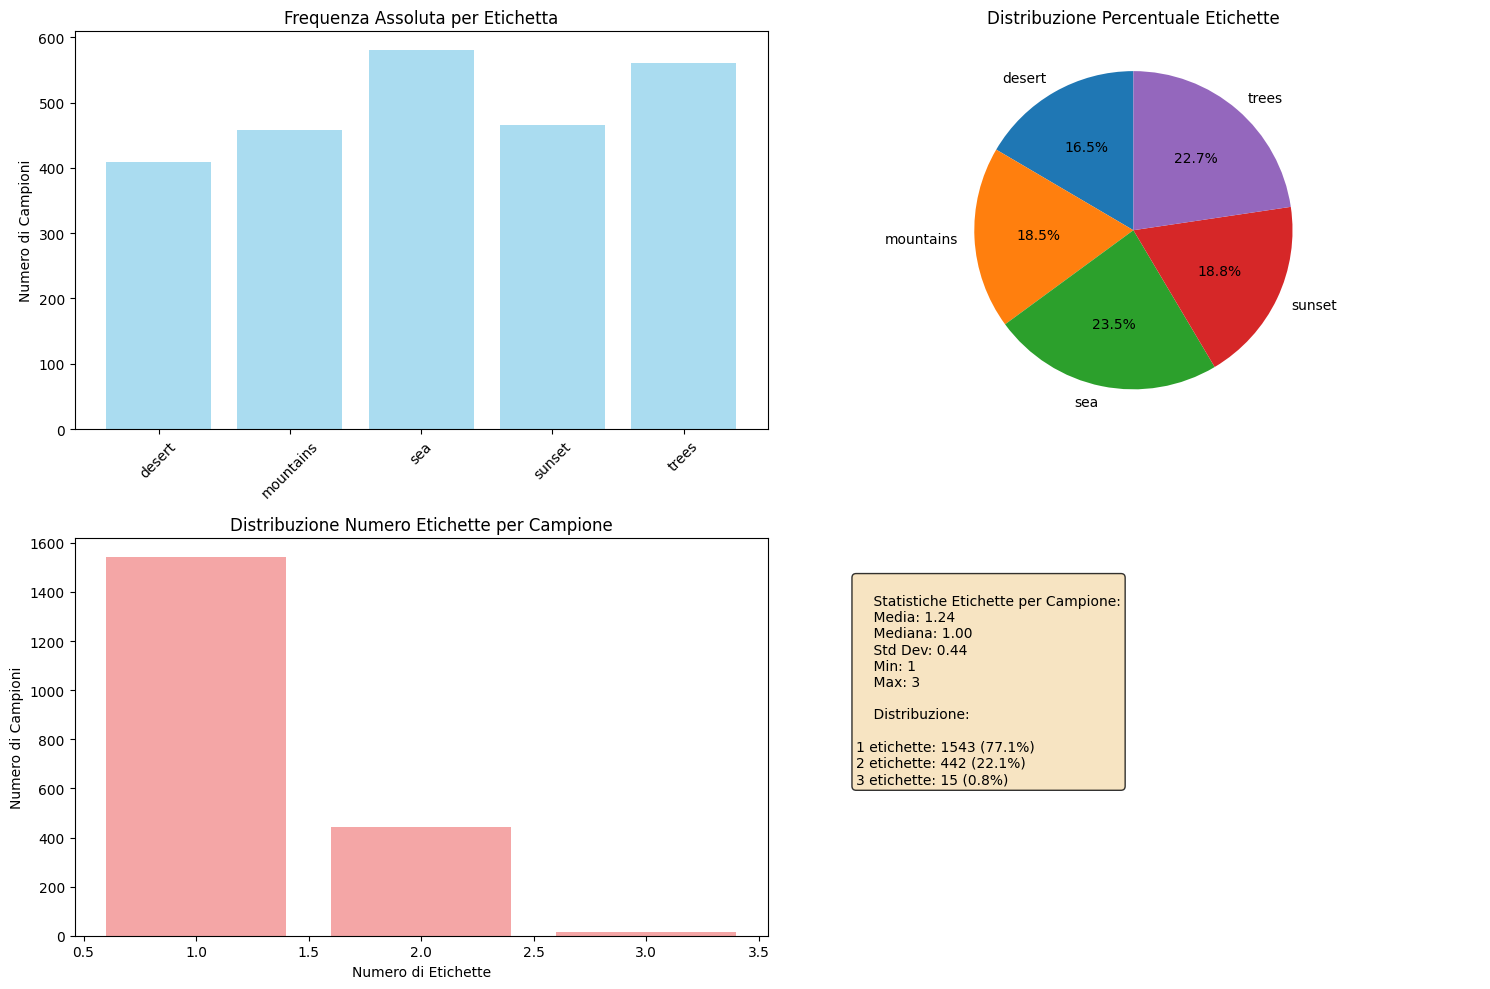

In [ ]:
# Analisi distribuzione etichette
label_counts, labels_per_sample = analyze_label_distribution(df, label_columns)


ANALISI COMBINAZIONI DI ETICHETTE
Numero totale di combinazioni uniche: 20
Numero massimo teorico di combinazioni: 32

Top 10 combinazioni più frequenti:
 1. ['trees'] - 378 campioni (18.9%)
 2. ['sea'] - 341 campioni (17.1%)
 3. ['desert'] - 340 campioni (17.0%)
 4. ['mountains'] - 268 campioni (13.4%)
 5. ['sunset'] - 216 campioni (10.8%)
 6. ['sea', 'sunset'] - 172 campioni (8.6%)
 7. ['mountains', 'trees'] - 106 campioni (5.3%)
 8. ['mountains', 'sea'] - 38 campioni (1.9%)
 9. ['sunset', 'trees'] - 28 campioni (1.4%)
10. ['desert', 'sunset'] - 21 campioni (1.1%)


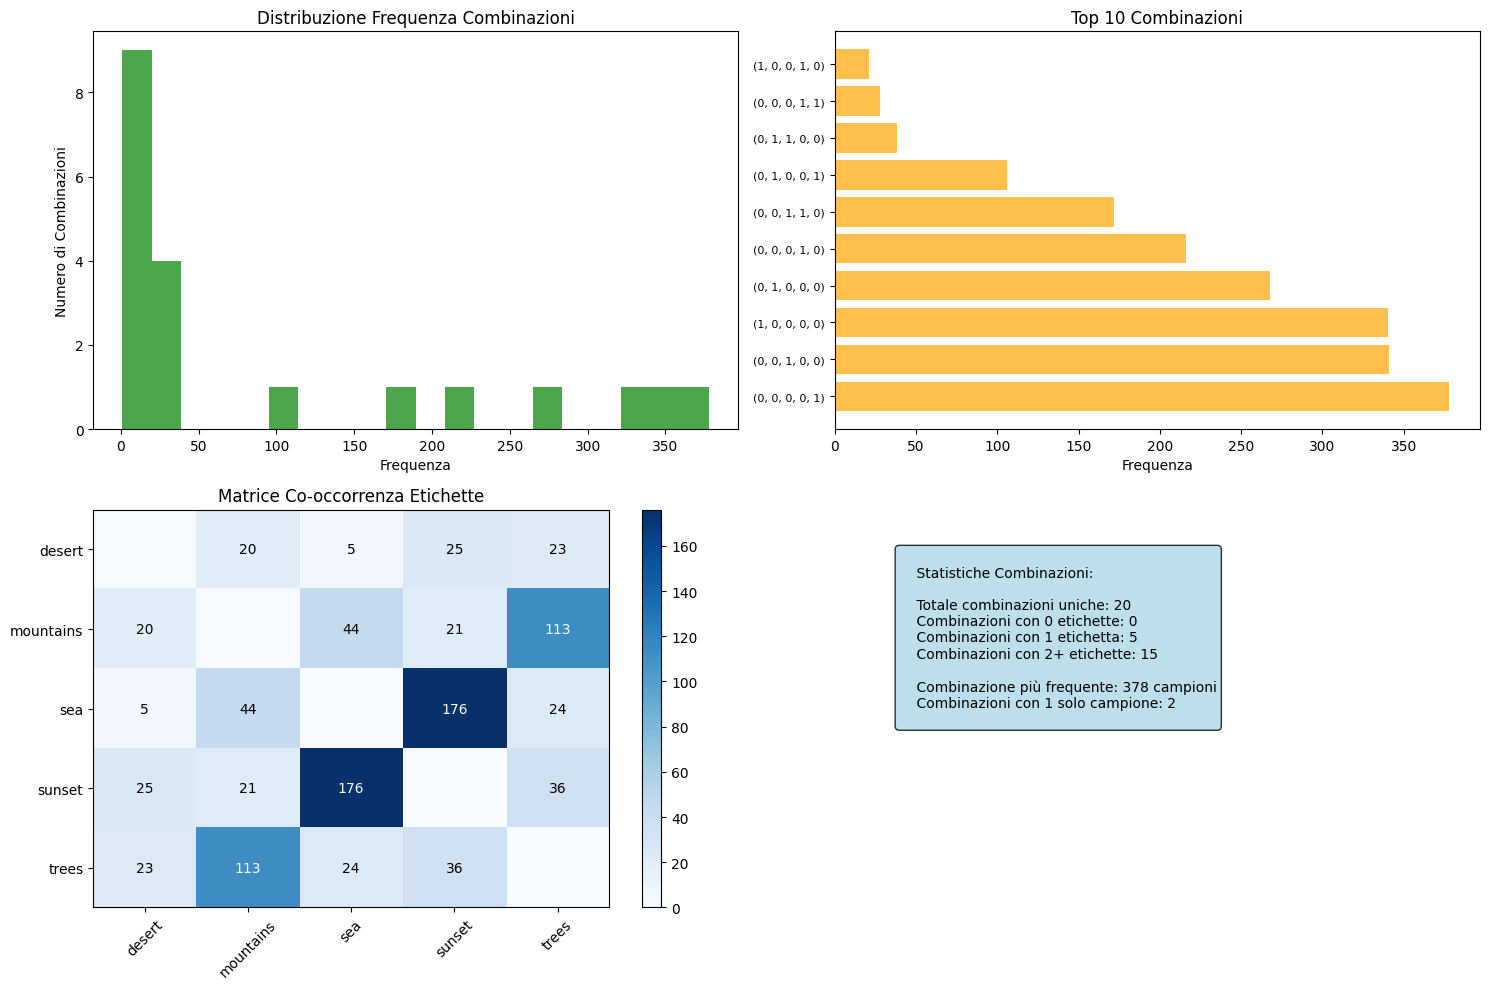

In [ ]:
# Analisi combinazioni etichette
combo_counts, cooccurrence_matrix = analyze_label_combinations(df, label_columns)


ANALISI DISTRIBUZIONE FEATURES
Numero di features: 135
Shape features: (2000, 135)

Statistiche descrittive:
          Feature1     Feature2     Feature3     Feature4     Feature5  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean    127.746250   130.199750   126.498875   118.481125   120.934375   
std      57.767357    57.583783    57.937689    54.972088    55.147310   
min       2.250000     1.000000     2.000000     0.250000     0.000000   
25%      84.500000    87.937500    82.687500    77.250000    79.250000   
50%     123.750000   126.250000   123.250000   114.750000   118.375000   
75%     168.312500   170.062500   168.062500   156.500000   158.750000   
max     254.500000   255.000000   254.750000   254.000000   254.000000   

          Feature6     Feature7     Feature8     Feature9    Feature10  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean    116.825875   108.411625   112.013500   108.957000   122.9

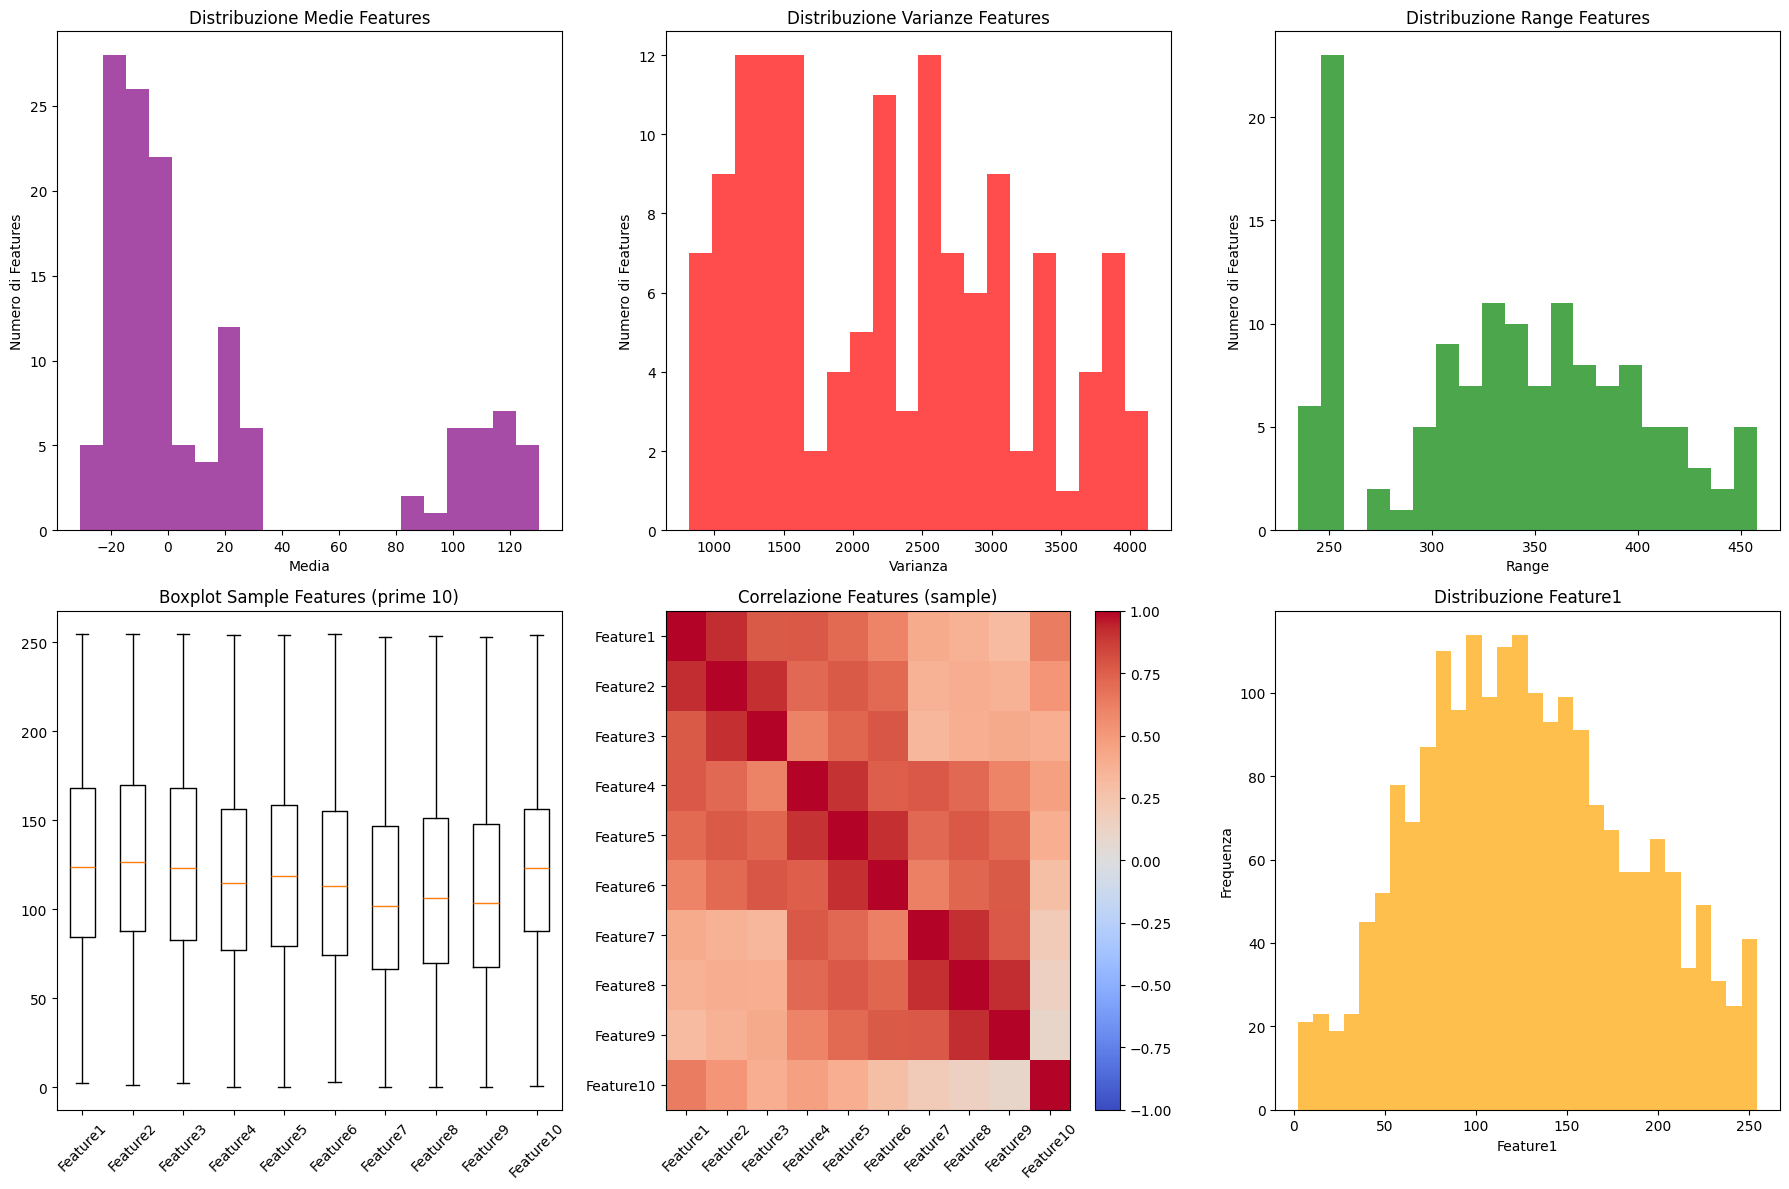

In [ ]:
# Analisi distribuzione features
X = analyze_feature_distributions(df, feature_columns)


ANALISI CORRELAZIONI
Analisi correlazioni tra features...
Coppie di features con correlazione > 0.8: 194

Analisi correlazioni tra labels...

Calcolo Mutual Information tra labels...

Analisi correlazioni features-labels...


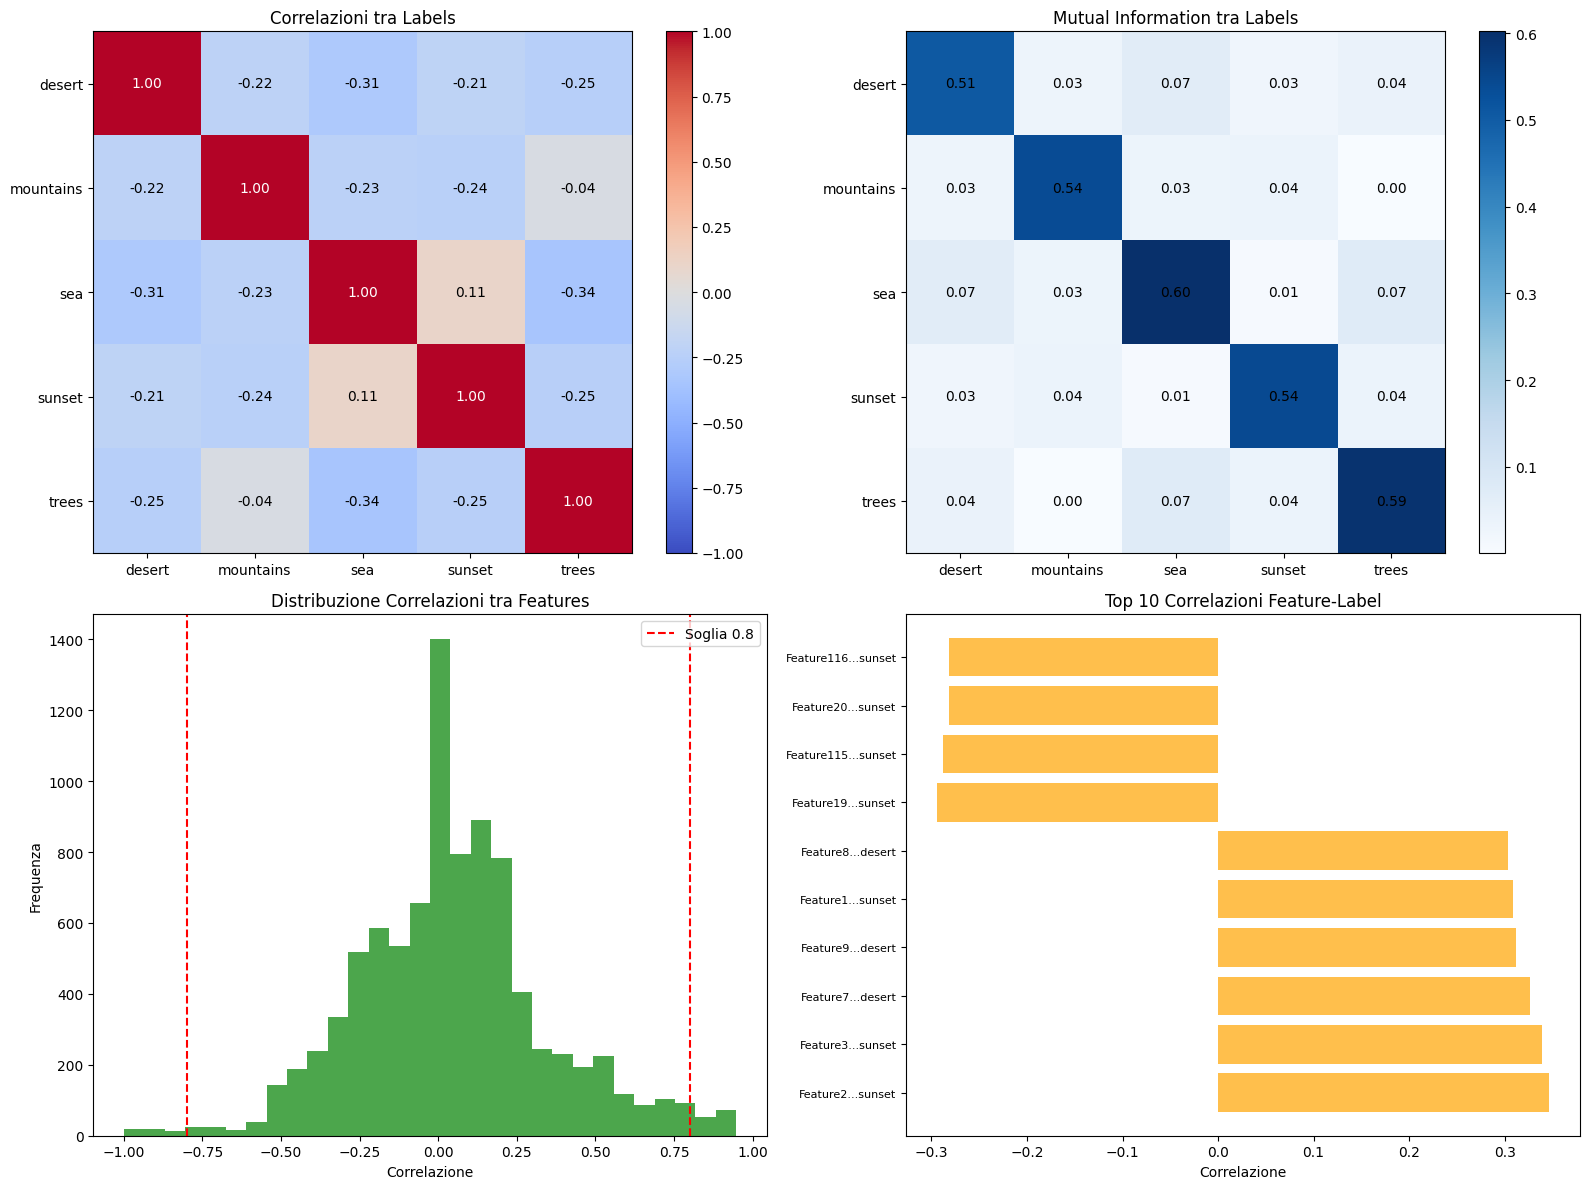

In [ ]:
# Analisi correlazioni complete
feature_corr, label_corr, mi_matrix, feature_label_corr = analyze_correlations(
    df, feature_columns, label_columns
)


ANALISI PCA
Componenti PCA calcolate: 45
Varianza spiegata dalle prime 2 componenti: 0.348
Varianza spiegata dalle prime 3 componenti: 0.483
Varianza spiegata dalle prime 10 componenti: 0.821


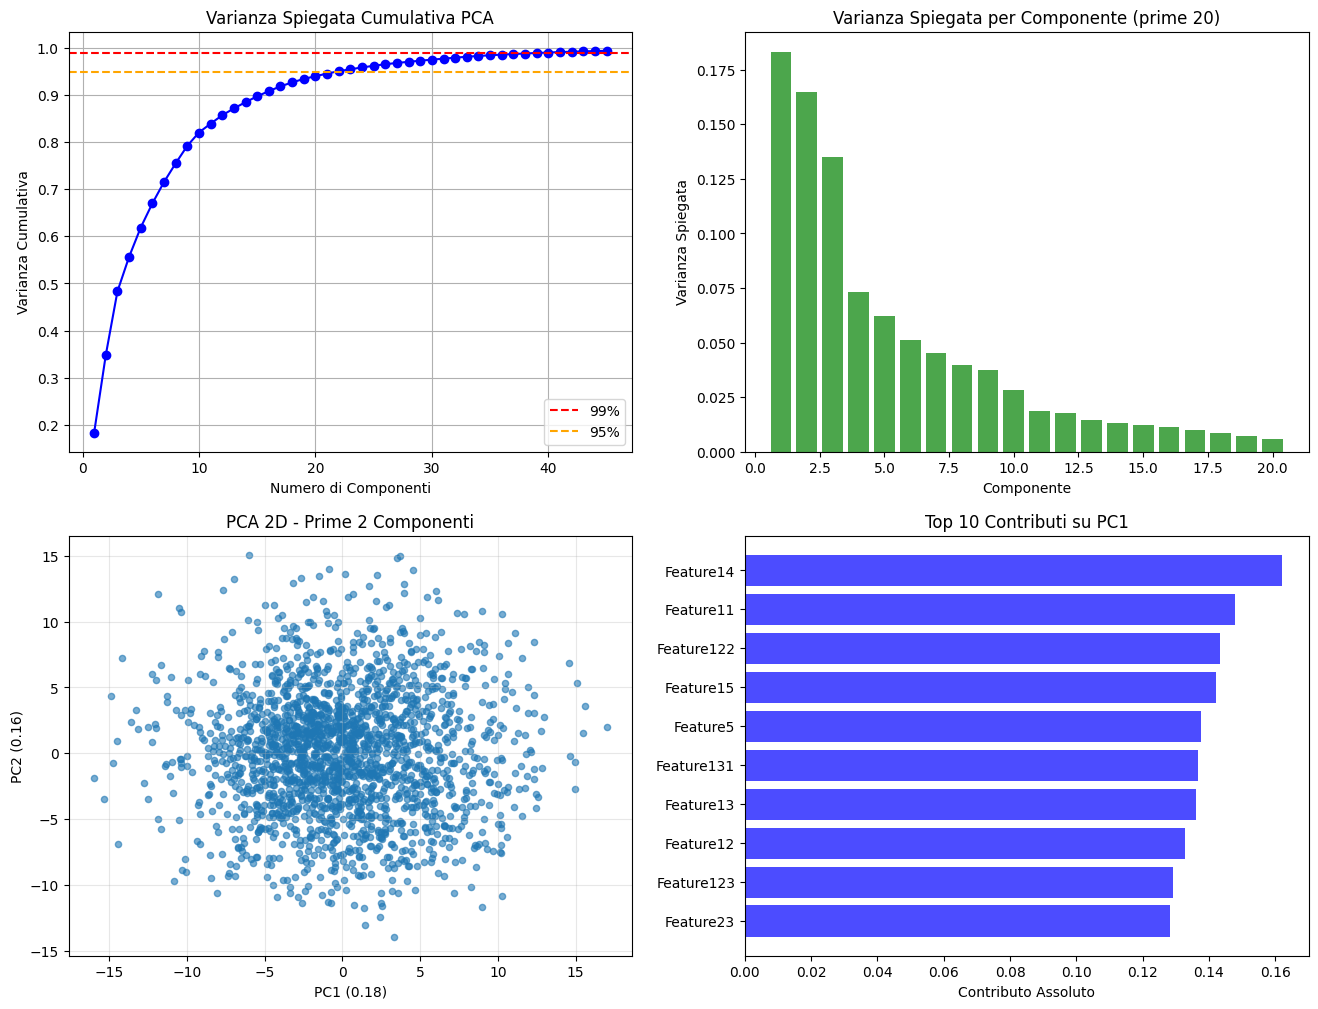

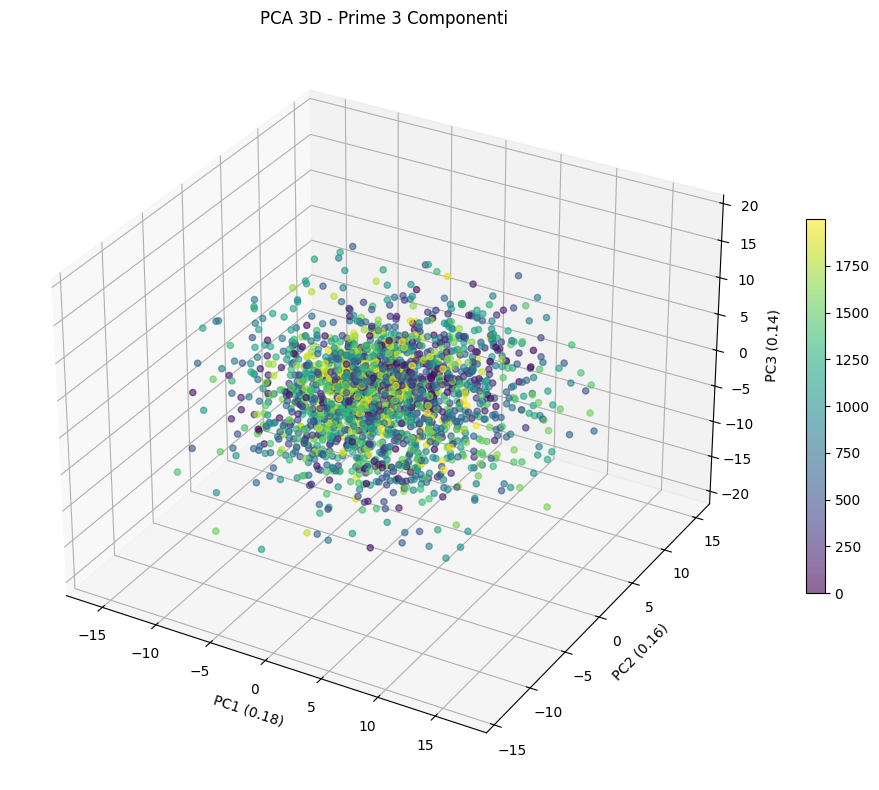

In [ ]:
# Analisi PCA completa
X_pca_2d, X_pca_3d, pca_2d, pca_3d, pca_full = analyze_pca(X, n_components=45)

# TOOL MODEL

## Definizione Ulteriori Fuzioni

Ogni problema ha bisogno di funciton per adattare i framework esistenti al **caso specifico** o implementare idee aggiuntive.




In [ ]:
def prepare_features_and_labels(df, feature_columns, label_columns):
    """
    Separa features e labels dal dataframe e crea feature derivate basilari
    """
    # Estrae le features originali
    X_original = df[feature_columns].values

    # Crea feature derivate
    derived_features = []

    # Statistiche di base
    row_means = np.mean(X_original, axis=1, keepdims=True)
    derived_features.append(row_means)

    row_medians = np.median(X_original, axis=1, keepdims=True)
    derived_features.append(row_medians)

    row_ranges = (np.max(X_original, axis=1) - np.min(X_original, axis=1)).reshape(-1, 1)
    derived_features.append(row_ranges)

    row_stds = np.std(X_original, axis=1, keepdims=True)
    derived_features.append(row_stds)

    row_vars = np.var(X_original, axis=1, keepdims=True)
    derived_features.append(row_vars)

    # Percentili
    row_p25 = np.percentile(X_original, 25, axis=1, keepdims=True)
    derived_features.append(row_p25)

    row_p75 = np.percentile(X_original, 75, axis=1, keepdims=True)
    derived_features.append(row_p75)

    # Somma
    row_sums = np.sum(X_original, axis=1, keepdims=True)
    derived_features.append(row_sums)

    # Skewness
    from scipy.stats import skew
    row_skewness = skew(X_original, axis=1, keepdims=True)
    derived_features.append(row_skewness)

    # Combina features originali e derivate
    X = np.hstack([X_original] + derived_features)

    # Estrae le labels
    y = df[label_columns].values.astype(int)

    print(f"Features: da {X_original.shape[1]} a {X.shape[1]} ({len(derived_features)} feature derivate aggiunte)")

    return X, y

def apply_pca(X_train, X_test, n_components=None):
    """
    Applica PCA alle features
    """
    if n_components is None:
        n_components = min(X_train.shape[0], X_train.shape[1])

    # Standardizzazione
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_test_pca, pca, scaler

def calculate_label_correlation_matrix(y, label_names):
    """
    Calcola la matrice di correlazione tra i label
    """
    correlation_matrix = np.corrcoef(y.T)

    # Converte in DataFrame per migliore visualizzazione
    correlation_df = pd.DataFrame(correlation_matrix,
                                 index=label_names,
                                 columns=label_names)
    return correlation_df

def plot_correlation_matrix(correlation_df, title="Label Correlation Matrix"):
    """
    Visualizza la matrice di correlazione
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def mutual_info_between_labels(df, label1, label2):
    mi = mutual_info_score(df[label1], df[label2])
    print(f"Mutual Information tra '{label1}' e '{label2}': {mi:.4f}")
    return mi

def conditional_prob(df, label1, label2):
    p = df[df[label2]==True][label1].mean()
    print(f"P({label1}=True | {label2}=True): {p:.2f}")
    return p

def plot_mutual_info_heatmap(df, categorical_cols):
    n = len(categorical_cols)
    mi_matrix = np.zeros((n, n))
    for i, col1 in enumerate(categorical_cols):
        for j, col2 in enumerate(categorical_cols):
            mi_matrix[i, j] = mutual_info_score(df[col1], df[col2])
    plt.figure(figsize=(7,6))
    sns.heatmap(mi_matrix, annot=True, fmt=".3f", xticklabels=categorical_cols, yticklabels=categorical_cols, cmap='Blues')
    plt.title("Heatmap Mutual Information tra le label")
    plt.tight_layout()
    plt.show()
    return mi_matrix

def plot_conditional_prob_heatmap(df, categorical_cols):
    n = len(categorical_cols)
    cp_matrix = np.zeros((n, n))
    for i, col1 in enumerate(categorical_cols):
        for j, col2 in enumerate(categorical_cols):
            if df[col2].sum() == 0:
                cp_matrix[i, j] = np.nan
            else:
                cp_matrix[i, j] = df[df[col2]==True][col1].mean()
    plt.figure(figsize=(7,6))
    sns.heatmap(cp_matrix, annot=True, fmt=".2f", xticklabels=categorical_cols, yticklabels=categorical_cols, cmap='Oranges')
    plt.title("P(A=True | B=True): righe=A, colonne=B")
    plt.tight_layout()
    plt.show()
    return cp_matrix

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean

def augment_rare_combinations(X, y, min_samples=5,Smote=False, target_ratio=0.3, max_synthetic_ratio=2):
    """
    Applica augmentazione selettiva per bilanciare le combinazioni di label:
    - Raddoppia le combinazioni con < min_samples istanze
    - Genera campioni sintetici per le combinazioni sottorappresentate rispetto al target

    Args:
        X: Features
        y: Multi-label targets
        min_samples: Soglia per definire combinazioni "rare"
        target_ratio: Frazione del numero di campioni della classe più frequente da raggiungere
        max_synthetic_ratio: Rapporto massimo tra campioni sintetici e originali (default: 5x)
    """

    # Converte le combinazioni di label in stringhe per contarle
    y_combinations = [','.join(map(str, row)) for row in y]
    unique_combinations, counts = np.unique(y_combinations, return_counts=True)

    # Trova la combinazione più frequente
    max_count = np.max(counts)
    target_count = int(max_count * target_ratio)

    # Classifica le combinazioni
    rare_combinations = unique_combinations[counts < min_samples]
    minority_combinations = unique_combinations[(counts >= min_samples) & (counts < target_count)]
    majority_combinations = unique_combinations[counts >= target_count]

    print(f"Combinazione più frequente: {max_count} campioni")
    print(f"Target per bilanciamento: {target_count} campioni ({target_ratio*100:.1f}% del massimo)")
    print(f"Trovate {len(rare_combinations)} combinazioni rare (<{min_samples} campioni)")
    print(f"Trovate {len(minority_combinations)} combinazioni minoritarie ({min_samples}-{target_count} campioni)")
    print(f"Trovate {len(majority_combinations)} combinazioni maggioritarie (>={target_count} campioni)")

    X_augmented = []
    y_augmented = []

    # Raddoppia le combinazioni rare
    for rare_combo in rare_combinations:
        indices = [i for i, combo in enumerate(y_combinations) if combo == rare_combo]
        print(f"Raddoppiando {len(indices)} campioni per combinazione rara: {rare_combo}")
        for idx in indices:
            X_augmented.append(X[idx])
            y_augmented.append(y[idx])
    if Smote:
      # Applica augmentazione alle combinazioni minoritarie per bilanciarle
      for minority_combo in minority_combinations:
          indices = [i for i, combo in enumerate(y_combinations) if combo == minority_combo]
          current_count = len(indices)

          # Calcola quanti campioni sintetici generare per raggiungere il target
          ideal_target = target_count - current_count

          # Limita il numero di campioni sintetici per evitare overfitting
          max_synthetic = current_count * max_synthetic_ratio
          actual_target = min(ideal_target, max_synthetic)

          print(f"Bilanciando combinazione minoritaria: {minority_combo}")
          print(f"  - Campioni attuali: {current_count}, target ideale: {target_count}")
          print(f"  - Campioni da generare: {actual_target} (limitato da max_ratio={max_synthetic_ratio}x)")

          if actual_target > 0 and len(indices) > 1:
              X_subset = X[indices]
              y_subset = y[indices]

              # Configura parametri per la generazione
              k_neighbors = min(min_samples, len(indices)) - 1

              try:
                  # Genera campioni sintetici
                  X_synthetic = generate_synthetic_multilabel(X_subset, y_subset, actual_target, k_neighbors)

                  if len(X_synthetic) > 0:
                      # Le etichette rimangono le stesse per i campioni sintetici
                      y_synthetic = np.tile(y_subset[0], (len(X_synthetic), 1))
                      X_augmented.extend(X_synthetic)
                      y_augmented.extend(y_synthetic)
                      final_count = current_count + len(X_synthetic)
                      print(f"  - Aggiunti {len(X_synthetic)} campioni sintetici ({current_count} -> {final_count})")
                  else:
                      print(f"  - Nessun campione sintetico generato")

              except Exception as e:
                  print(f"  - Augmentazione fallita: {e}")
          elif actual_target <= 0:
              print(f"  - Nessuna augmentazione necessaria")
          else:
              print(f"  - Saltato: solo {len(indices)} campioni, serve almeno 2")

      # Le combinazioni maggioritarie non vengono toccate
      for majority_combo in majority_combinations:
          indices = [i for i, combo in enumerate(y_combinations) if combo == majority_combo]
          print(f"Combinazione maggioritaria saltata: {majority_combo} ({len(indices)} campioni)")

    if len(X_augmented) > 0:
        X_final = np.vstack([X, np.array(X_augmented)])
        y_final = np.vstack([y, np.array(y_augmented)])
    else:
        X_final, y_final = X, y

    print(f"Dataset augmentato: da {X.shape[0]} a {X_final.shape[0]} campioni")
    return X_final, y_final


def generate_synthetic_multilabel(X, y, n_synthetic, k_neighbors):
    """
    Genera campioni sintetici per dati multilabel usando interpolazione
    tra nearest neighbors nello spazio delle features
    """
    if len(X) <= 1:
        return []

    # Usa NearestNeighbors per trovare i vicini
    k = min(k_neighbors + 1, len(X))  # +1 perché include il punto stesso
    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean')
    nbrs.fit(X)

    synthetic_samples = []
    np.random.seed(42)

    for _ in range(n_synthetic):
        # Seleziona un campione casuale come punto di partenza
        base_idx = np.random.randint(0, len(X))
        base_sample = X[base_idx]

        # Trova i suoi nearest neighbors
        distances, indices = nbrs.kneighbors([base_sample])

        # Rimuovi il campione stesso dalla lista dei vicini
        neighbor_indices = indices[0][1:]  # Salta il primo (se stesso)

        if len(neighbor_indices) > 0:
            # Seleziona un vicino casuale
            neighbor_idx = np.random.choice(neighbor_indices)
            neighbor_sample = X[neighbor_idx]

            # Genera un campione sintetico tramite interpolazione
            # Usa un fattore di interpolazione casuale tra 0 e 1
            alpha = np.random.random()
            synthetic_sample = base_sample + alpha * (neighbor_sample - base_sample)
            synthetic_samples.append(synthetic_sample)

    return synthetic_samples

def plot_pca_explained_variance(pca, title="PCA Explained Variance"):
    """
    Visualizza la varianza spiegata da PCA
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(title)
    plt.grid(True)
    plt.show()

# =============================================================================
# NUOVE FUNZIONI PER MODELLI MULTIPLI E OTTIMIZZAZIONE
# =============================================================================

def get_model_configurations():
    """
    Definisce i modelli e i rispettivi iperparametri per l'ottimizzazione
    """
    models = {
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'estimator__n_estimators': [50, 75, 100, 200],
                'estimator__max_depth': [15, 20, 25],
                'estimator__min_samples_split': [2, 4, 6]
            },
        },
        'LogisticRegression': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'params': {
                'estimator__C': [0.1, 1, 10],
                'estimator__penalty': ['l2'],
                'estimator__solver': ['lbfgs']
            },
        },
        'SVC': {
            'model': SVC(random_state=42, probability=True),
            'params': {
                'estimator__C': [0.1, 1, 10],
                'estimator__kernel': ['rbf', 'linear'],
                'estimator__gamma': ['scale', 'auto']
            },
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'estimator__n_estimators': [ 100, 200],
                'estimator__learning_rate': [0.05, 0.1, 0.2],
                'estimator__max_depth': [3, 5, 7]
            }
            ,
        },
        'MLPClassifier': {
            'model': MLPClassifier(
                random_state=42,
                max_iter=1000,  # Aumentato da 500
                early_stopping=True,  # Ferma quando non migliora più
                validation_fraction=0.1,  # Frazione per early stopping
                n_iter_no_change=20,  # Iterazioni senza miglioramento
                tol=1e-4  # Tolleranza per la convergenza
            ),
            'params': {
                'estimator__hidden_layer_sizes': [(64,), (128,), (128, 64), (64, 64)],
                'estimator__alpha': [0.0001, 0.001, 0.01],  # Regolarizzazione
                'estimator__learning_rate_init': [0.001, 0.01],  # Learning rate iniziale
                'estimator__solver': ['adam']  # Algoritmi di ottimizzazione
            },
        }
    }
    return models

import joblib
def optimize_model_hyperparameters(X_train, y_train, model_name, model_config, cv=3):
    """
    Ottimizza gli iperparametri di un modello usando GridSearchCV
    """
    print(f"\nOttimizzazione iperparametri per {model_name}...")

    # Crea il classificatore multi-output
    multilabel_classifier = MultiOutputClassifier(model_config['model'])

    # Esegui grid search
    grid_search = GridSearchCV(
        multilabel_classifier,
        model_config['params'],
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Migliori parametri per {model_name}: {grid_search.best_params_}")
    print(f"Miglior score: {grid_search.best_score_:.3f}")

    best = grid_search.best_estimator_
    joblib.dump(best, f"{model_name}_best.joblib")
    print(f"Saved best estimator for {model_name}")
    return grid_search.best_estimator_

def predict_probabilities_enhanced(classifier, X_test):
    """
    Predice le probabilità per ogni classe - versione migliorata
    """
    probabilities = []

    for i, estimator in enumerate(classifier.estimators_):
        if hasattr(estimator, 'predict_proba'):
            prob = estimator.predict_proba(X_test)
            if prob.shape[1] > 1:
                probabilities.append(prob[:, 1])
            else:
                probabilities.append(np.ones(X_test.shape[0]))
        else:
            # Per modelli che non supportano predict_proba
            pred = estimator.predict(X_test)
            probabilities.append(pred.astype(float))

    return np.array(probabilities).T

def enhanced_prediction_with_matrix(y_prob, matrix, model_config, threshold=0.3):
    """
    Usa la correlazione per migliorare le predizioni
    """
    enhanced_predictions = []

    for prob_vector in y_prob:
        # Trova la label con probabilità più alta
        primary_label_idx = np.argmax(prob_vector)

        # Moltiplica il vettore probabilità per la riga della matrice di correlazione
        matrix=pd.DataFrame(matrix)
        x= matrix.iloc[primary_label_idx].values
        row = (x - x.min()) / (x.max() - x.min())

        prob_vector=(prob_vector - prob_vector.min()) / (prob_vector.max() - prob_vector.min())
        adjusted_prob = prob_vector * row

        # Trova la seconda label con probabilità più alta
        sorted_indices = np.argsort(adjusted_prob)[::-1]
        secondary_label_idx = sorted_indices[1]
        secondary_prob = adjusted_prob[secondary_label_idx]

        # Crea predizione finale
        final_prediction = np.zeros(len(prob_vector))
        final_prediction[primary_label_idx] = 1

        # Aggiungi la seconda label se supera la soglia
        if secondary_prob > threshold:
            final_prediction[secondary_label_idx] = 1

        enhanced_predictions.append(final_prediction)

    counts = Counter(np.sum(v) for v in enhanced_predictions)
    # Stampa risultati ordinati
    for num_ones in sorted(counts):
        print(f"Vettori con {num_ones} uno: {counts[num_ones]}")
    return np.array(enhanced_predictions)

def multilabel_distribution(df, categorical_cols):
    last5 = df[categorical_cols]
    num_label_per_instance = last5.sum(axis=1)
    counts = num_label_per_instance.value_counts().sort_index()
    percentuali = (counts / len(df)) * 100
    for n in counts.index:
        print(f"{n} label attive: {counts[n]} istanze ({percentuali[n]:.2f}%)")
    plt.bar(counts.index, percentuali)
    plt.xlabel('Numero di label attive')
    plt.ylabel('Percentuale di istanze')
    plt.title('Distribuzione numero di label attive per istanza')
    plt.show()
    return num_label_per_instance

def reduce_trilabel_to_bilabel(df, categorical_cols, num_label_per_instance, method='correlation'):
    """
    Riduce le istanze con 3 label attive a 2 label attive,
    rimuovendo la label con associazione più debole.

    Args:
        df: DataFrame completo
        categorical_cols: nomi delle colonne delle label
        num_label_per_instance: Serie con numero di label attive per istanza
        method: 'conditional_prob' o 'mutual_info' o 'correlation'

    Returns:
        DataFrame modificato
    """
    df_modified = df.copy()

    # Calcola la matrice di associazione secondo il metodo scelto
    n = len(categorical_cols)
    association_matrix = np.zeros((n, n))

    if method == 'conditional_prob':
        # Probabilità condizionata P(A=True | B=True)
        for i, col1 in enumerate(categorical_cols):
            for j, col2 in enumerate(categorical_cols):
                if df[col2].sum() == 0:
                    association_matrix[i, j] = 0
                else:
                    association_matrix[i, j] = df[df[col2]==True][col1].mean()

    elif method == 'mutual_info':
        # Mutual Information
        from sklearn.metrics import mutual_info_score
        for i, col1 in enumerate(categorical_cols):
            for j, col2 in enumerate(categorical_cols):
                association_matrix[i, j] = mutual_info_score(df[col1], df[col2])

    elif method == 'correlation':
        # Correlazione di Pearson
        corr_matrix = df[categorical_cols].astype(int).corr()
        association_matrix = corr_matrix.values

    # Trova le istanze con esattamente 3 label attive
    print(num_label_per_instance)
    trilabel_mask = num_label_per_instance == 3
    print(trilabel_mask)
    trilabel_indices = df[trilabel_mask].index
    print(trilabel_indices)
    print(f"Trovate {len(trilabel_indices)} istanze con 3 label attive")
    print(f"Metodo utilizzato: {method}")

    removal_stats = {}

    for idx in trilabel_indices:
        # Trova quali label sono attive per questa istanza
        active_labels = [col for col in categorical_cols if df.loc[idx, col] == True]

        if len(active_labels) == 3:
            # Calcola il "punteggio di associazione" per ogni label con le altre due
            scores = {}

            for i, label in enumerate(active_labels):
                other_labels = [active_labels[j] for j in range(3) if j != i]

                # Punteggio = media delle associazioni con le altre due label
                label_idx = list(categorical_cols).index(label)
                other_idx1 = list(categorical_cols).index(other_labels[0])
                other_idx2 = list(categorical_cols).index(other_labels[1])

                score = (association_matrix[label_idx, other_idx1] + association_matrix[label_idx, other_idx2]) / 2
                scores[label] = score

            # Trova la label con punteggio più basso (da rimuovere)
            print(score)
            print(min(scores, key=scores.get))
            label_to_remove = min(scores, key=scores.get)

            # Aggiorna statistiche
            removal_stats[label_to_remove] = removal_stats.get(label_to_remove, 0) + 1

            # Rimuovi la label
            df_modified.loc[idx, label_to_remove] = False

            print(f"Istanza {idx}: rimossa '{label_to_remove}' (score: {scores[label_to_remove]:.3f})")

    print("\nStatistiche rimozioni:")
    for label, count in removal_stats.items():
        print(f"  {label}: {count} volte")

    return df_modified
# =============================================================================
# NUOVE FUNZIONI PER ANALISI ERRORI E CLASSIFICATION REPORT
# =============================================================================

def detailed_error_analysis(y_true, y_pred, y_prob, label_names, model_name):
    """
    Analisi dettagliata degli errori per classe
    """
    print(f"\n{'='*60}")
    print(f"ANALISI ERRORI DETTAGLIATA - {model_name}")
    print(f"{'='*60}")

    # 1. Classification Report per ogni classe
    print("\n1. CLASSIFICATION REPORT PER CLASSE:")
    print("-" * 50)

    # Calcola precision, recall, f1 per ogni classe
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # Crea un DataFrame per visualizzare meglio
    metrics_df = pd.DataFrame({
        'Label': label_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    print(metrics_df.round(3).to_string(index=False))

    # 2. Analisi degli errori per tipo
    # print("\n2. ANALISI ERRORI PER TIPO:")
    # print("-" * 50)

    error_analysis = {}
    for i, label in enumerate(label_names):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]

        # Calcola i diversi tipi di errore
        true_positives = np.sum((y_true_label == 1) & (y_pred_label == 1))
        false_positives = np.sum((y_true_label == 0) & (y_pred_label == 1))
        false_negatives = np.sum((y_true_label == 1) & (y_pred_label == 0))
        true_negatives = np.sum((y_true_label == 0) & (y_pred_label == 0))

        total_samples = len(y_true_label)

        error_analysis[label] = {
            'TP': true_positives,
            'FP': false_positives,
            'FN': false_negatives,
            'TN': true_negatives,
            'FP_rate': false_positives / total_samples,
            'FN_rate': false_negatives / total_samples,
            'Error_rate': (false_positives + false_negatives) / total_samples
        }

        # print(f"\n{label}:")
        # print(f"  True Positives: {true_positives:4d} | False Positives: {false_positives:4d}")
        # print(f"  False Negatives: {false_negatives:4d} | True Negatives: {true_negatives:4d}")
        # print(f"  FP Rate: {false_positives/total_samples:.3f} | FN Rate: {false_negatives/total_samples:.3f}")
        # print(f"  Error Rate: {(false_positives + false_negatives)/total_samples:.3f}")


    # 3. Analisi delle combinazioni di errore
    print("\n3. ANALISI COMBINAZIONI DI ERRORE:")
    print("-" * 50)

    # Calcola quante predizioni hanno 0, 1, 2, ... errori
    error_counts = []
    for i in range(len(y_true)):
        errors = np.sum(y_true[i] != y_pred[i])
        error_counts.append(errors)

    error_distribution = Counter(error_counts)
    total_samples = len(y_true)

    print("Distribuzione errori per campione:")
    for num_errors in sorted(error_distribution.keys()):
        count = error_distribution[num_errors]
        percentage = (count / total_samples) * 100
        print(f"  {num_errors} errori: {count:4d} campioni ({percentage:.1f}%)")

    return error_analysis, metrics_df

def plot_error_analysis(error_analysis, metrics_df, model_name):
    """
    Visualizza l'analisi degli errori
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Error Analysis - {model_name}', fontsize=16)

    labels = list(error_analysis.keys())

    # 1. Error rates per classe
    error_rates = [error_analysis[label]['Error_rate'] for label in labels]
    axes[0, 0].bar(labels, error_rates, color='red', alpha=0.7)
    axes[0, 0].set_title('Error Rate per Classe')
    axes[0, 0].set_ylabel('Error Rate')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. F1-Score per classe
    f1_scores = metrics_df['F1-Score'].values
    axes[0, 1].bar(labels, f1_scores, color='green', alpha=0.7)
    axes[0, 1].set_title('F1-Score per Classe')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. False Positive vs False Negative rates
    fp_rates = [error_analysis[label]['FP_rate'] for label in labels]
    fn_rates = [error_analysis[label]['FN_rate'] for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    axes[1, 0].bar(x - width/2, fp_rates, width, label='False Positive Rate', color='orange', alpha=0.7)
    axes[1, 0].bar(x + width/2, fn_rates, width, label='False Negative Rate', color='blue', alpha=0.7)
    axes[1, 0].set_title('FP vs FN Rate per Classe')
    axes[1, 0].set_ylabel('Rate')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(labels, rotation=45)
    axes[1, 0].legend()

    # 4. Precision vs Recall
    precision = metrics_df['Precision'].values
    recall = metrics_df['Recall'].values

    axes[1, 1].scatter(precision, recall, s=100, alpha=0.7)
    for i, label in enumerate(labels):
        axes[1, 1].annotate(label, (precision[i], recall[i]),
                           xytext=(5, 5), textcoords='offset points')
    axes[1, 1].set_title('Precision vs Recall')
    axes[1, 1].set_xlabel('Precision')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model_comprehensive(y_true, y_pred, y_prob, label_names, model_name,error=False):
    """
    Valutazione completa del modello con analisi errori
    """
    # Metriche standard
    metrics = {
        'model': model_name,
        'hamming_loss': hamming_loss(y_true, y_pred),
        'exact_match_accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_micro': f1_score(y_true, y_pred, average='micro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }

    # Analisi dettagliata degli errori
    if error:
        error_analysis, metrics_df = detailed_error_analysis(y_true, y_pred, y_prob, label_names, model_name)

    return metrics

def train_and_evaluate_all_models(X_train, X_test, y_train, y_test,
                                  matrix, label_names, Threshold=0.2,
                                  optimize_hyperparams=True,analisi=True, Train=True):
    """
    Addestra e valuta tutti i modelli con analisi errori dettagliata
    """
    models = get_model_configurations()
    results = []
    trained_models = {}

    for model_name, model_config in models.items():
        print(f"\n=== MODEL: {model_name} ===")
        filename = f"FeatureImage_Analysis/{model_name}_best.joblib"
        if not Train:
            try:
                classifier = joblib.load(filename)
                print(f"Loaded pre‑trained model for {model_name}")
            except FileNotFoundError:
                print(f"No saved model found for {model_name}, training now...")
                Train = True  # for this model
        if Train:
            if optimize_hyperparams:
                classifier = optimize_model_hyperparameters( X_train, y_train, model_name, model_config)
            else:
                classifier = MultiOutputClassifier(model_config['model'])
                classifier.fit(X_train, y_train)

        # Predizioni standard
        y_pred = classifier.predict(X_test)
        y_prob = predict_probabilities_enhanced(classifier, X_test)

        # Valutazione standard CON ANALISI ERRORI
        metrics_standard = evaluate_model_comprehensive(
            y_test, y_pred, y_prob, label_names, f"{model_name}_standard"
        )

        # Predizioni e probabilità sul TRAIN
        y_pred_train = classifier.predict(X_train)
        y_prob_train = predict_probabilities_enhanced(classifier, X_train)

        # Valutazione su TRAIN (senza plot per non sovraccaricare)
        train_metrics = {
            'hamming_loss': hamming_loss(y_train, y_pred_train),
            'exact_match_accuracy': accuracy_score(y_train, y_pred_train),
            'f1_macro': f1_score(y_train, y_pred_train, average='macro')
        }

        # Stampa confronto Train vs Test
        print(f"\n{model_name} - TRAIN vs TEST (Standard):")
        print(f"Hamming Loss TRAIN: {train_metrics['hamming_loss']:.3f} | TEST: {metrics_standard['hamming_loss']:.3f} | Diff: {(metrics_standard['hamming_loss'] - train_metrics['hamming_loss']):.3f}")
        print(f"F1 Macro TRAIN: {train_metrics['f1_macro']:.3f} | TEST: {metrics_standard['f1_macro']:.3f} | Diff: {(metrics_standard['f1_macro'] - train_metrics['f1_macro']):.3f}")

        results.append(metrics_standard)

        # Predizioni enhanced con matrice correlazione o cooccorrenza
        enhanced_pred = enhanced_prediction_with_matrix(
            y_prob, matrix, model_name, threshold=Threshold
        )

        # Valutazione enhanced CON ANALISI ERRORI
        metrics_enhanced = evaluate_model_comprehensive(
            y_test, enhanced_pred, y_prob, label_names, f"{model_name}_enhanced",error=True
        )
        results.append(metrics_enhanced)

        # Salva il modello addestrato
        trained_models[model_name] = {
            'classifier': classifier,
            'standard_pred': y_pred,
            'enhanced_pred': enhanced_pred,
            'probabilities': y_prob
        }

        if Train:
            joblib.dump(classifier, filename)
            print(f"Saved model {filename}")

        print(f"\n{model_name} - SUMMARY:")
        print(f"Standard  - Hamming: {metrics_standard['hamming_loss']:.3f} | Exact Match: {metrics_standard['exact_match_accuracy']:.3f} | F1: {metrics_standard['f1_macro']:.3f}")
        print(f"Enhanced  - Hamming: {metrics_enhanced['hamming_loss']:.3f} | Exact Match: {metrics_enhanced['exact_match_accuracy']:.3f} | F1: {metrics_enhanced['f1_macro']:.3f}")

        continue

    return results, trained_models

def create_comparison_table(results):
    """
    Crea una tabella di confronto dei risultati
    """
    df_results = pd.DataFrame(results)

    # Ordina per F1 Macro score
    df_results = df_results.sort_values('f1_macro', ascending=False)

    # Formatta i numeri per una migliore visualizzazione
    numeric_columns = ['hamming_loss', 'exact_match_accuracy', 'f1_macro', 'f1_micro', 'f1_weighted']
    for col in numeric_columns:
        df_results[col] = df_results[col].round(4)

    return df_results

def Ensamble_model(results, trained_models, y_test, label_columns, soglia):
    # Estrai i risultati enhanced e ordina per exact_match_accuracy decrescente
    enhanced_results = [r for r in results if r['model'].endswith('_enhanced')]
    # scegli i top  (modifica k se vuoi più o meno)
    k = 5
    topk = sorted(enhanced_results, key=itemgetter('exact_match_accuracy'), reverse=True)[:k]
    best_models = [r['model'].replace('_enhanced','') for r in topk]
    print(f"\n {k} modelli enhanced selezionati per l'ensemble: {best_models}")

    # Raccogli le probabilità dai trained_models
    prob_list = []
    for name in best_models:
        prob = trained_models[name]['probabilities']  # shape (n_samples, n_labels)
        prob_list.append(prob)
    # stack e media
    mean_prob = np.mean(np.stack(prob_list, axis=2), axis=2)

    # Predizione multi-label per threshold
    ensemble_threshold = soglia  # o scegli un valore diverso
    y_pred_ensemble = (mean_prob >= ensemble_threshold).astype(int)

    # Valutazione finale
    ensemble_metrics = evaluate_model_comprehensive(
        y_test,
        y_pred_ensemble,
        mean_prob,
        label_columns,
        model_name=f"Ensemble_top{k}"
    )
    print("\n--- Risultati Ensemble ---")
    for m, v in ensemble_metrics.items():
        if m!='model':
            print(f"{m}: {v:.3f}")
    ensemble=pd.DataFrame({k: [v] for k, v in ensemble_metrics.items()})
    return ensemble

def plot_model_comparison(df_results):
    """
    Visualizza il confronto tra i modelli
    """
    # Prepara i dati per il plotting
    metrics_to_plot = ['hamming_loss', 'exact_match_accuracy', 'f1_macro']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]

        # Separa standard e enhanced
        standard_models = df_results[df_results['model'].str.contains('standard')]
        enhanced_models = df_results[df_results['model'].str.contains('enhanced')]

        # Estrai nomi dei modelli
        standard_names = [name.replace('_standard', '') for name in standard_models['model']]
        enhanced_names = [name.replace('_enhanced', '') for name in enhanced_models['model']]

        x = np.arange(len(standard_names))
        width = 0.35

        # Inverti hamming_loss per una migliore visualizzazione (più basso è meglio)
        if metric == 'hamming_loss':
            standard_values = 1 - standard_models[metric].values
            enhanced_values = 1 - enhanced_models[metric].values
            ylabel = f'1 - {metric}'
        else:
            standard_values = standard_models[metric].values
            enhanced_values = enhanced_models[metric].values
            ylabel = metric

        ax.bar(x - width/2, standard_values, width, label='Standard', alpha=0.8)
        ax.bar(x + width/2, enhanced_values, width, label='Enhanced', alpha=0.8)

        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{metric} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(standard_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from operator import itemgetter
from collections import Counter

In [ ]:
FILE = "FeatureImage_Analysis/file275473ee134d.arff"
LABELS = ["sea", "sunset", "trees", "mountains", "desert"]
df = load_arff_to_df(FILE)
label_columns = df.columns[-5:].tolist()
feature_columns = df.columns[:-5].tolist()
df[label_columns] = df[label_columns].applymap(lambda x: x.decode('utf-8') == 'TRUE' if isinstance(x, bytes) else x == 'TRUE')
Force_Bilabel=False

if Force_Bilabel:
    num_label_per_instance = multilabel_distribution(df_processed, label_columns)
    df_processed=reduce_trilabel_to_bilabel(df_processed, label_columns, num_label_per_instance)

/tmp/ipython-input-12-3292500636.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[label_columns] = df[label_columns].applymap(lambda x: x.decode('utf-8') == 'TRUE' if isinstance(x, bytes) else x == 'TRUE')


## Preprocessing

Nelle seguenti sezioni di codice andremo a preparare il dataframe alle successive fasi di training e valutazione dei modelli, nel pratico consiste in:
* Separazione Features da Labels
* Aggiunta di Features Derivate
* Gestione del bilanciamento delle classi
* Splitting del dataset
* Dimensionality reduction e Scaling

In [ ]:
print("\nSTEP 2: Separazione features e labels...")
X, y = prepare_features_and_labels(df, feature_columns, label_columns)
print(f"Shape features: {X.shape}")
print(f"Shape labels: {y.shape}")


STEP 2: Separazione features e labels...
Features: da 135 a 144 (9 feature derivate aggiunte)
Shape features: (2000, 144)
Shape labels: (2000, 5)


In [ ]:
print("\nSTEP 2.5: Augmentazione delle combinazioni rare...")
X_augmented, y_augmented = augment_rare_combinations(X, y, min_samples=5)


STEP 2.5: Augmentazione delle combinazioni rare...
Combinazione più frequente: 378 campioni
Target per bilanciamento: 113 campioni (30.0% del massimo)
Trovate 4 combinazioni rare (<5 campioni)
Trovate 10 combinazioni minoritarie (5-113 campioni)
Trovate 6 combinazioni maggioritarie (>=113 campioni)
Raddoppiando 4 campioni per combinazione rara: 0,0,1,1,1
Raddoppiando 1 campioni per combinazione rara: 0,1,0,1,1
Raddoppiando 3 campioni per combinazione rara: 1,0,0,1,1
Raddoppiando 1 campioni per combinazione rara: 1,1,0,1,0
Dataset augmentato: da 2000 a 2009 campioni


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)

In [ ]:
n_components = 45
X_train_pca, X_test_pca, pca, scaler = apply_pca(X_train, X_test, n_components)

In [ ]:
correlation_matrix = calculate_label_correlation_matrix(y_train, label_columns)

cooccurrence_matrix = np.zeros((len(label_columns), len(label_columns)))
for i, label1 in enumerate(label_columns):
    for j, label2 in enumerate(label_columns):
        cooccurrence_matrix[i, j] = ((df[label1] == 1) & (df[label2] == 1)).sum()

## Train or Load Modelli

**Modelli addestrati**

Poiché il dataset è etichettato, i modelli di machine learning utilizzati per la classificazione rientrano nell’ambito del learning supervisionato, ovvero durante la fase di addestramento il modello riceve anche le etichette corrette associate a ciascun campione.
Al fine di identificare la strategia più adatta, abbiamo confrontato le prestazioni di diversi classificatori in base agli ipeparametri ottimali precedentemente individuati.

Usiamo un *wrapper* `MultiOutputClassifier` per trasformare classificatori tradizionali in multi‑label:

* **Random Forest** – algoritmo di classificazione che consiste in una
raccolta di alberi decisionali i cui risultati vengono aggregati in un
unico risultato finale. Il modello mostra buone performance grazie alla sua capacità di gestire feature correlate. La natura ensemble dell’algoritmo for-
nisce naturalmente una certa resistenza all’overfitting.
* **Logistic Regression** – algoritmo di classificazione supervisionata usato per prevedere probabilità e assegnare etichette di classe a nuovi esempi. Nonostante il nome, non è un metodo di regressione, ma serve per classificare dati. La semplicità del modello offre vantaggi in termini di interpretabilità e velocità di addestramento. Le performance della Regressione Logistica forniscono un baseline importante per valutare la complessità necessaria per il problema di classificazione.
* **Gradient Boosting** – rientra nella categoria dei metodi Ensemble, infatti costruisce un modello predittivo combinando molti modelli deboli (alberi decisionali nel caso standard) in modo iterativo, dove ogni nuovo albero cerca di correggere gli errori commessi dagli alberi precedenti. Esso apprende dall'errore residuo direttamente, piuttosto che aggiornare i pesi dei punti dati, e fa una nuova previsione semplicemente sommando le previsioni (di tutti gli alberi).
* **SVC (RBF)** –  trova un iperpiano che separa i dati in
diverse classi nel miglior modo possibile, se i dati non possono es-
sere separati da un iperpiano in modo lineare, SVC utilizza il ker-
nel trick. Il kernel RBF è stato utilizzato per catturare relazioni non linea-
ri nei dati. La natura del SVC che massimizza il margine tra le classi risulta
particolarmente utile in contesti con molte feature.
* **MLP Classifier** – tipo di rete neurale artificiale appartenente alla categoria delle feedforward neural networks. È uno dei modelli più semplici e utilizzati nel deep learning, soprattutto per problemi di classificazione e regressione. Esso è composto da più strati (layer) di neuroni, ciascuno completamente connesso al successivo.

**Selezione iperparametri**  
Con `GridSearchCV` ottimizziamo parametri chiave (p. es. `n_estimators`, `C`, `hidden_layer_sizes`) usando *f1_macro* e cross‑validation stratificata a 5 fold.
In questo blocco addestriamo il modello di machine learning e salviamo i risultati.

In [ ]:
soglia=0.18 #0.35 per correlation
results, trained_models = train_and_evaluate_all_models(
    X_train_pca, X_test_pca, y_train, y_test,
    cooccurrence_matrix , label_columns, Threshold=soglia,
    optimize_hyperparams=True,analisi=False,Train=False)


=== MODEL: RandomForest ===
Loaded pre‑trained model for RandomForest

RandomForest - TRAIN vs TEST (Standard):
Hamming Loss TRAIN: 0.040 | TEST: 0.192 | Diff: 0.152
F1 Macro TRAIN: 0.905 | TEST: 0.402 | Diff: -0.503
Vettori con 1.0 uno: 347
Vettori con 2.0 uno: 55

ANALISI ERRORI DETTAGLIATA - RandomForest_enhanced

1. CLASSIFICATION REPORT PER CLASSE:
--------------------------------------------------
    Label  Precision  Recall  F1-Score  Support
   desert      0.737   0.512     0.604       82
mountains      0.567   0.370     0.447       92
      sea      0.496   0.581     0.535      117
   sunset      0.719   0.681     0.699       94
    trees      0.640   0.640     0.640      114

3. ANALISI COMBINAZIONI DI ERRORE:
--------------------------------------------------
Distribuzione errori per campione:
  0 errori:  176 campioni (43.8%)
  1 errori:   86 campioni (21.4%)
  2 errori:  112 campioni (27.9%)
  3 errori:   28 campioni (7.0%)

RandomForest - SUMMARY:
Standard  - Hamming: 0

## Valutazione del modello

**Metriche riportate**

Per valutare le prestazioni dei modelli in questione (quando ogni campione può essere associato a più etichette contemporaneamente) abbiamo utilizzato le seguenti metriche multilabel:

* **Hamming Loss** – quota di etichette predette in modo errato. Più bassa è meglio (0 = perfetto).
* **Exact Match Accuracy** – percentuale di esempi in cui *tutte* le etichette sono corrette (metrica severa).
* **F1 Macro** – media aritmetica delle F1 delle singole classi, indipendente dalla loro frequenza.

Di base si vuole valutare quanto bene il
modello predice l’insieme corretto di etichette per ciascun esempio.

Mostriamo sia la versione **standard** (output diretto) che **enhanced** (dopo correzione usando la matrice di correlazione fra etichette).
Valutiamo le performance del modello utilizzando metriche appropriate.
Valutiamo le performance del modello utilizzando metriche appropriate.

In [ ]:
df_comparison = create_comparison_table(results)
df_comparison = df_comparison.sort_values(by="exact_match_accuracy", ascending=False)

In [ ]:
print(df_comparison.to_string(index=False, float_format="%.4f"))

                      model  hamming_loss  exact_match_accuracy  f1_macro  f1_micro  f1_weighted
  GradientBoosting_enhanced        0.1955                0.4602    0.5800    0.5841       0.5817
      RandomForest_enhanced        0.1960                0.4378    0.5854    0.5879       0.5854
LogisticRegression_enhanced        0.2154                0.4204    0.5300    0.5389       0.5330
     MLPClassifier_enhanced        0.2418                0.3781    0.4854    0.4916       0.4875
               SVC_enhanced        0.2388                0.3607    0.4911    0.4947       0.4917
  GradientBoosting_standard        0.1891                0.3259    0.5333    0.5411       0.5380
LogisticRegression_standard        0.1990                0.3134    0.4997    0.5062       0.5004
               SVC_standard        0.2164                0.2935    0.4926    0.4971       0.4940
     MLPClassifier_standard        0.2174                0.2761    0.4856    0.4889       0.4875
      RandomForest_standard   

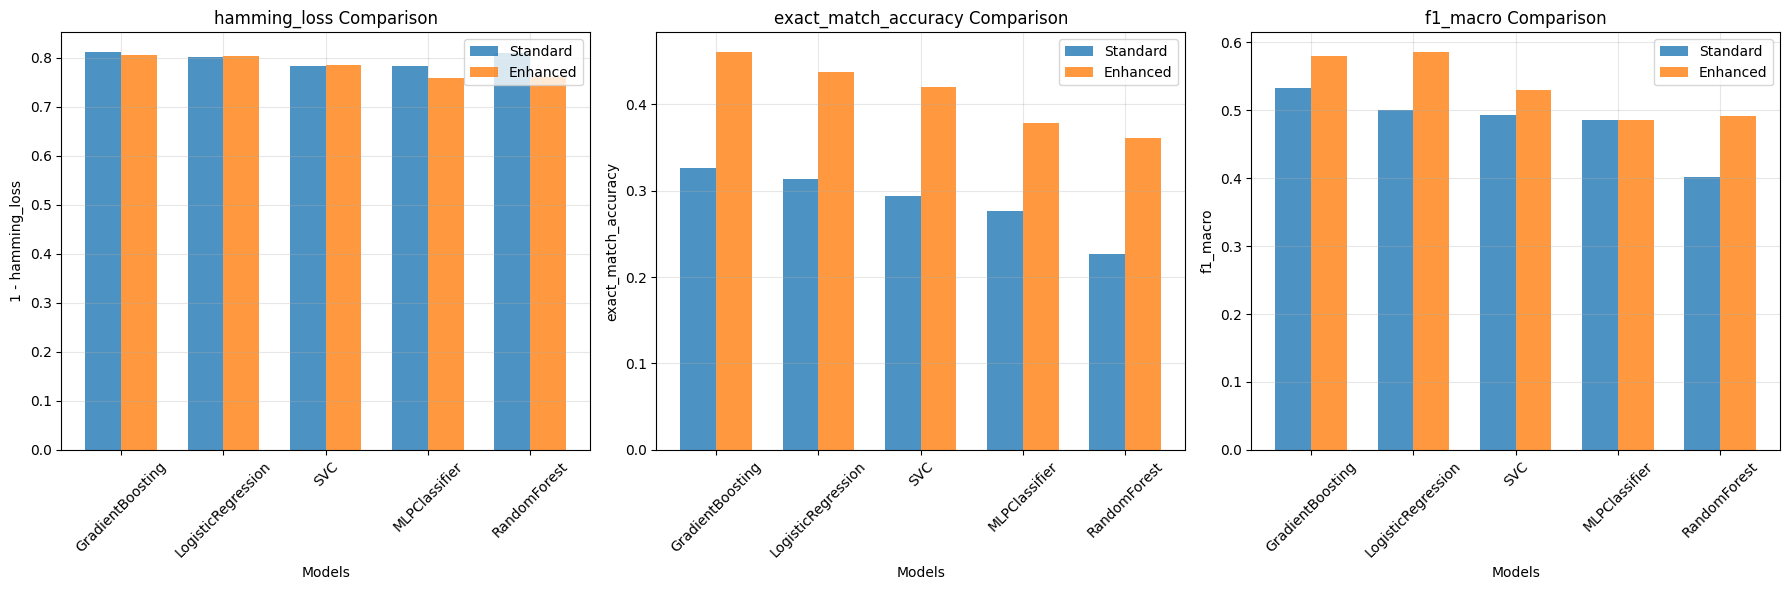

In [ ]:
plot_model_comparison(df_comparison)

## Ensamble Model



In [ ]:
ensemble_metrics = Ensamble_model(results, trained_models, y_test, label_columns, soglia)
df_comparison = pd.concat([df_comparison,ensemble_metrics], ignore_index=True)
df_comparison = df_comparison.sort_values('exact_match_accuracy', ascending=False)
print("\nTABELLA AGGIORNATA CON ENSEMBLE:")
print(df_comparison.to_string(index=False, float_format="%.4f"))


Migliori 5 modelli enhanced selezionati per l'ensemble: ['GradientBoosting', 'RandomForest', 'LogisticRegression', 'MLPClassifier', 'SVC']

--- Risultati Ensemble ---
hamming_loss: 0.313
exact_match_accuracy: 0.152
f1_macro: 0.558
f1_micro: 0.559
f1_weighted: 0.559

TABELLA AGGIORNATA CON ENSEMBLE:
                      model  hamming_loss  exact_match_accuracy  f1_macro  f1_micro  f1_weighted
  GradientBoosting_enhanced        0.1955                0.4602    0.5800    0.5841       0.5817
      RandomForest_enhanced        0.1960                0.4378    0.5854    0.5879       0.5854
LogisticRegression_enhanced        0.2154                0.4204    0.5300    0.5389       0.5330
     MLPClassifier_enhanced        0.2418                0.3781    0.4854    0.4916       0.4875
               SVC_enhanced        0.2388                0.3607    0.4911    0.4947       0.4917
  GradientBoosting_standard        0.1891                0.3259    0.5333    0.5411       0.5380
LogisticRegression_s